<a href="https://colab.research.google.com/github/nxxk23/bsc_dpdm22/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data Describes
- [Bank Marketing Campaign Dataset](https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset)



```
# - A. Attributes Description:`
Input variables:

- Ai. bank client data:
1.  age: (numeric)
2.  job: type of job (categorical: 'admin.','blue-collar','entrepreneur', 'housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3.   marital: marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4.  education: (categorical: primary, secondary, tertiary and unknown)
5.  default: has credit in default? (categorical: 'no','yes','unknown')
6.  housing: has housing loan? (categorical: 'no','yes','unknown')
7.  loan: has personal loan? (categorical: 'no','yes','unknown')
8.  balance: Balance of the individual.

- Aii. Related with the last contact of the current campaign:
9   contact: contact communication type (categorical: 'cellular','telephone')
10   month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
11   day: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
12   duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

- Aiii. other attributes:
13   campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
14   pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
15   previous: number of contacts performed before this campaign and for this client (numeric)
16   poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

Output variable (desired target):
17   y - has the client subscribed a term deposit? (binary: 'yes','no')
```




In [2]:
import os
import warnings
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import pickle
import plotly.graph_objects as go
import plotly.express as px 
from sklearn.svm import SVC
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder,OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/content/drive/MyDrive/DPDM/Project/bank.csv')

**Class Distribution**
class distribution is more or less similar, not exactly 50:50 distribution but still good enough.

In [4]:
df['deposit'].value_counts()

no     5873
yes    5289
Name: deposit, dtype: int64

**Information on Term Suscriptions**


```
สัดส่วนของคนที่สมัครและไม่ได้สมัครรับ Term of suscriptions จำแนกตาม level of graduate และ state of loans
```


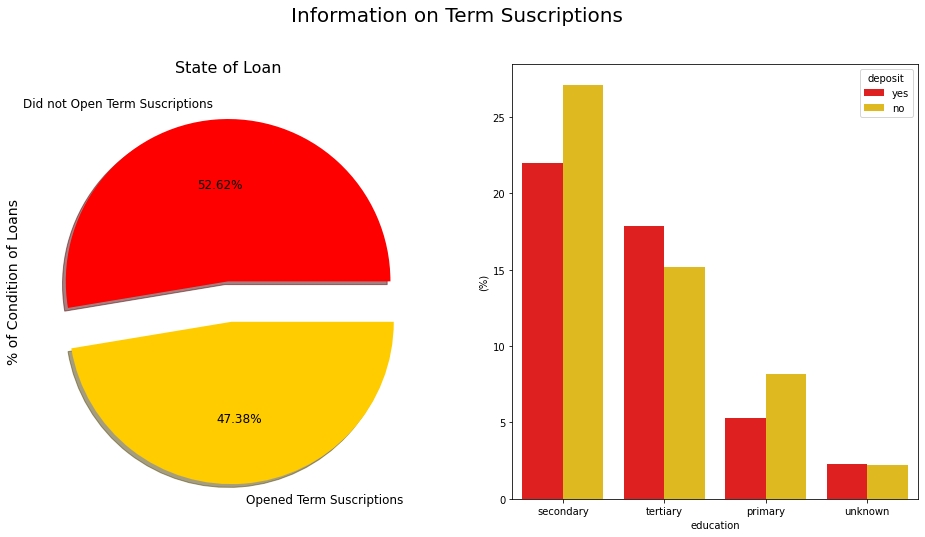

In [5]:
f, ax = plt.subplots(1,2, figsize=(16,8))
colors = ["#FF0000", "#FFCC00"]
labels ="Did not Open Term Suscriptions", "Opened Term Suscriptions"
plt.suptitle('Information on Term Suscriptions', fontsize=20)

df["deposit"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax[0], shadow=True, labels=labels, colors=colors, fontsize=12)

ax[0].set_title('State of Loan', fontsize=16)
ax[0].set_ylabel('% of Condition of Loans', fontsize=14)

sns.barplot(x="education", y="balance", hue="deposit", data=df, palette=colors, estimator=lambda x: len(x) / len(df) * 100)
ax[1].set(ylabel="(%)")
ax[1].set_xticklabels(df["education"].unique(), rotation=0, rotation_mode="anchor")
plt.show()

**Data information**

In [6]:
#how divorced have a considerably low amount of balance.
from plotly import tools
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
fig = ff.create_facet_grid(
    df,
    x='duration',
    y='balance',
    color_name='marital',
    show_boxes=False,
    marker={'size': 10, 'opacity': 1.0},
    colormap={'single': 'rgb(165, 242, 242)', 'married': 'rgb(253, 174, 216)', 'divorced': 'rgba(201, 109, 59, 0.82)'}
)

iplot(fig, filename='facet - custom colormap')

In [7]:
fig = ff.create_facet_grid(df, y='balance', facet_row='marital', facet_col='deposit', trace_type='box')

iplot(fig, filename='facet - box traces')

In [8]:
#which occupation tended to have more balance in their accounts

suscribed_df = df.loc[df["deposit"] == "yes"]

occupations = df["job"].unique().tolist()

# Get the balances by jobs
management = suscribed_df["age"].loc[suscribed_df["job"] == "management"].values
technician = suscribed_df["age"].loc[suscribed_df["job"] == "technician"].values
services = suscribed_df["age"].loc[suscribed_df["job"] == "services"].values
retired = suscribed_df["age"].loc[suscribed_df["job"] == "retired"].values
blue_collar = suscribed_df["age"].loc[suscribed_df["job"] == "blue-collar"].values
unemployed = suscribed_df["age"].loc[suscribed_df["job"] == "unemployed"].values
entrepreneur = suscribed_df["age"].loc[suscribed_df["job"] == "entrepreneur"].values
housemaid = suscribed_df["age"].loc[suscribed_df["job"] == "housemaid"].values
self_employed = suscribed_df["age"].loc[suscribed_df["job"] == "self-employed"].values
student = suscribed_df["age"].loc[suscribed_df["job"] == "student"].values

ages = [management, technician, services, retired, blue_collar, unemployed, 
         entrepreneur, housemaid, self_employed, student]

colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)',
          'rgba(44, 160, 101, 0.5)', 'rgba(255, 65, 54, 0.5)', 
          'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)',
         'rgba(229, 126, 56, 0.5)', 'rgba(229, 56, 56, 0.5)',
         'rgba(174, 229, 56, 0.5)', 'rgba(229, 56, 56, 0.5)']

traces = []

for xd, yd, cls in zip(occupations, ages, colors):
        traces.append(go.Box(
            y=yd,
            name=xd,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=cls,
            marker=dict(
                size=2,
            ),
            line=dict(width=1),
        ))

layout = go.Layout(
    title='Distribution of Ages by Occupation',
    yaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=5,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='rgb(251,251,251)',
    plot_bgcolor='rgb(251,251,251)',
    showlegend=False
)
fig = go.Figure(data=traces, layout=layout)
iplot(fig)

# Data Pre-Processing


## Import Data

In [9]:
# Import libraries
## Basic libs
import pandas as pd
import numpy as np
import warnings
## Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Configure libraries
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('seaborn')
#import data
df = pd.read_csv('/content/drive/MyDrive/DPDM/Project/bank.csv')
term_deposits = df.copy()
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


##**Drop column**

```
As the data information said it will be better to drop **the duration column** เนื่องจากระยะเวลามีความสัมพันธ์ต่อผลลัพธ์ที่ว่าว่าลูกค้าจะซื้อเงินฝากระยะยาวหรือไม่ 
นอกจากนี้คอลัมน์นี้ยังนับเวลาของลูกค้าที่โทรไปแต่ไม่รับสาย ดังนั้น คอลัมน์นี้ก็ไม่มีประโยชน์ 
เหตุผลที่ระยะเวลามีความสัมพันธ์อย่างมากกับการเปิดเงินฝากประจำ เนื่องจากยิ่งธนาคารพูดคุยกับลูกค้าเป้าหมายมากเท่าใด ความน่าจะเป็นที่ลูกค้าเป้าหมายจะเปิดเงินฝากประจำก็จะยิ่งสูงขึ้น 
เนื่องจากระยะเวลาที่สูงขึ้นหมายถึง higher interest (commitment)ที่สูงขึ้นจากลูกค้า
```



In [10]:

# Drop 'duration' column
df_bank = df.drop('duration', axis=1)

# print(df_bank.info())
print('Shape of dataframe:', df_bank.shape)
df_bank.head()

Shape of dataframe: (11162, 16)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,2,-1,0,unknown,yes


## Missing Values

> No missing values.




In [11]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  campaign   11162 non-null  int64 
 12  pdays      11162 non-null  int64 
 13  previous   11162 non-null  int64 
 14  poutcome   11162 non-null  object
 15  deposit    11162 non-null  object
dtypes: int64(6), object(10)
memory usage: 1.4+ MB


###Numeruic Features
```
how the numeric data is distributed.
```



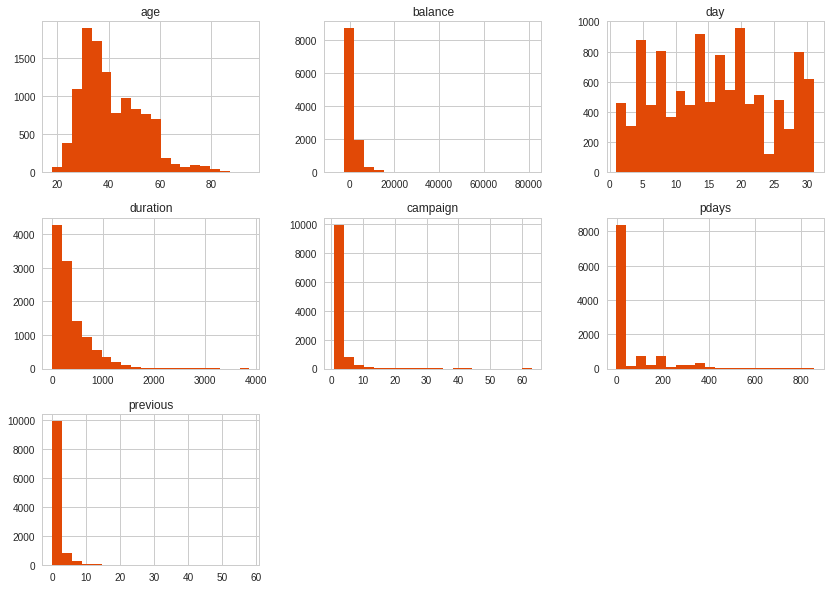

In [12]:
#how the numeric data is distributed.
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

df.hist(bins=20, figsize=(14,10), color='#E14906')
plt.show();

###**Important features**

```
The top three most important features for our classifier are 
- ระยะเวลา (ระยะเวลาที่ใช้ในการสนทนาระหว่างตัวแทนขายและผู้มีโอกาสเป็นลูกค้า)
- ผู้ติดต่อ (จำนวนผู้ติดต่อกับผู้มีโอกาสเป็นลูกค้าภายในแคมเปญการตลาดเดียวกัน)
- บ้าน (ลูกค้ามีบ้านหรือไม่ [binary])
```


```
คุณสมบัติใดที่มีอิทธิพลต่อผลลัพธ์ของการสมัครสมาชิกแบบฝากประจำ?
```



In [13]:
term_deposits

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


Feature ranking:
1. feature 11 (0.591310)
2. feature 8 (0.129966)
3. feature 6 (0.067020)
4. feature 13 (0.049923)
5. feature 15 (0.038138)
6. feature 14 (0.037830)
7. feature 10 (0.026646)
8. feature 5 (0.025842)
9. feature 0 (0.017757)
10. feature 12 (0.007889)
11. feature 3 (0.005280)
12. feature 9 (0.002200)
13. feature 2 (0.000147)
14. feature 1 (0.000050)
15. feature 7 (0.000000)
16. feature 4 (0.000000)


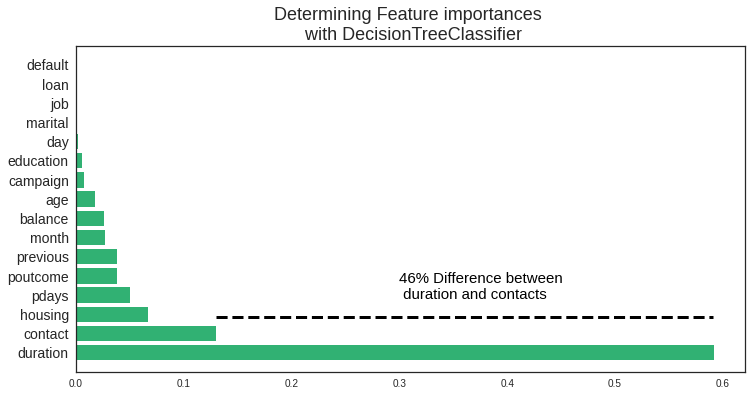

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
plt.style.use('seaborn-white')

# Convert the columns into categorical variables
term_deposits['job'] = term_deposits['job'].astype('category').cat.codes
term_deposits['marital'] = term_deposits['marital'].astype('category').cat.codes
term_deposits['education'] = term_deposits['education'].astype('category').cat.codes
term_deposits['contact'] = term_deposits['contact'].astype('category').cat.codes
term_deposits['poutcome'] = term_deposits['poutcome'].astype('category').cat.codes
term_deposits['month'] = term_deposits['month'].astype('category').cat.codes
term_deposits['default'] = term_deposits['default'].astype('category').cat.codes
term_deposits['loan'] = term_deposits['loan'].astype('category').cat.codes
term_deposits['housing'] = term_deposits['housing'].astype('category').cat.codes

# Create train and test splits
target_name = 'deposit'
X = term_deposits.drop('deposit', axis=1)


# Let's create new splittings like before but now we modified the data so we need to do it one more time.
label=term_deposits[target_name]
X_train, X_test, y_train, y_test = train_test_split(X,label,test_size=0.2, random_state=42, stratify=label)

# Build a classification task using 3 informative features
tree = tree.DecisionTreeClassifier(class_weight='balanced', min_weight_fraction_leaf = 0.01)



tree = tree.fit(X_train, y_train)
importances = tree.feature_importances_
feature_names = term_deposits.drop('deposit', axis=1).columns
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(12,6))
    plt.title("Determining Feature importances \n with DecisionTreeClassifier", fontsize=18)
    plt.barh(range(len(indices)), importances[indices], color='#31B173',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])
    plt.axhline(y=1.85, xmin=0.21, xmax=0.952, color='k', linewidth=3, linestyle='--')
    plt.text(0.30, 2.8, '46% Difference between \n duration and contacts', color='k', fontsize=15)
    
feature_importance_graph(indices, importances, feature_names)
plt.show()

In [15]:
term_deposits

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,0,1,1,0,2343,1,0,2,5,8,1042,1,-1,0,3,yes
1,56,0,1,1,0,45,0,0,2,5,8,1467,1,-1,0,3,yes
2,41,9,1,1,0,1270,1,0,2,5,8,1389,1,-1,0,3,yes
3,55,7,1,1,0,2476,1,0,2,5,8,579,1,-1,0,3,yes
4,54,0,1,2,0,184,0,0,2,5,8,673,2,-1,0,3,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,1,2,0,0,1,1,0,0,20,0,257,1,-1,0,3,no
11158,39,7,1,1,0,733,0,0,2,16,6,83,4,-1,0,3,no
11159,32,9,2,1,0,29,0,0,0,19,1,156,2,-1,0,3,no
11160,43,9,1,1,0,0,0,1,0,8,8,9,2,172,5,0,no


###**Data Correlation**

In [16]:
term_deposits = term_deposits.drop('duration', axis=1)

In [17]:
data = term_deposits

In [18]:
data['deposit'].mask(data['deposit'] == 'no', 0 , inplace=True)
data['deposit'].mask(data['deposit'] == 'yes', 1 , inplace=True)
data['deposit']= data['deposit'].astype('float64')

In [19]:
### spliting data en X et Y
X= data.drop('deposit', axis=1)
Y= data['deposit']

<Axes: >

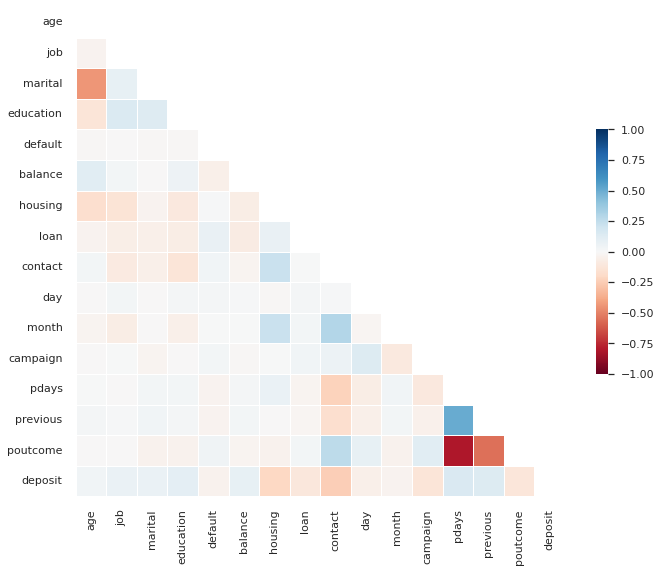

In [20]:
sns.set_theme(style="white")
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.color_palette("RdBu", as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [21]:
df_bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,2,172,5,failure,no


#**Classification**

## Scale Numeric Data

Next up, we will scale our numerical data to avoid outlier presence that can significantly affect our model. Using `StandardScaler()` function from sklearn we can scale each our columns that contains numerical data.

ปรับข้อมูลเพื่อหลีกเลี่ยงค่า outlier เพราะส่งผลกระทบต่อโมเดล

In [22]:
from sklearn.preprocessing import StandardScaler

# Copying original dataframe
df_bank_ready = df_bank.copy()

scaler = StandardScaler()
num_cols = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']
df_bank_ready[num_cols] = scaler.fit_transform(df_bank_ready[num_cols])

df_bank_ready.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit
0,1.491505,admin.,married,secondary,no,0.252525,yes,no,unknown,-1.265746,may,-0.554168,-0.481184,-0.36326,unknown,yes
1,1.239676,admin.,married,secondary,no,-0.459974,no,no,unknown,-1.265746,may,-0.554168,-0.481184,-0.36326,unknown,yes
2,-0.019470,technician,married,secondary,no,-0.080160,yes,no,unknown,-1.265746,may,-0.554168,-0.481184,-0.36326,unknown,yes
3,1.155733,services,married,secondary,no,0.293762,yes,no,unknown,-1.265746,may,-0.554168,-0.481184,-0.36326,unknown,yes
4,1.071790,admin.,married,tertiary,no,-0.416876,no,no,unknown,-1.265746,may,-0.186785,-0.481184,-0.36326,unknown,yes


## Encode Categorical Value

Same as the numerical data, we also need to pre-process our categorical data from words to number to make it easier for the computer to understands. To do this we will use `OneHotEncoder()` provided by sklearn. Basically it will transform a categorical column from this:

| marital | housing |
|----------|---------|
| single   | yes     |
| divorced | no      |
| married  | no      |

...into something like this...

| marital_single | marital_divorced | marital_married | housing_yes | housing_no |
|----------------|------------------|-----------------|-------------|------------|
| 1              | 0                | 0               | 1           | 0          |
| 0              | 1                | 0               | 0           | 1          |
| 0              | 0                | 1               | 0           | 1          |


In [23]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

# Encode Categorical Data
df_encoded = pd.DataFrame(encoder.fit_transform(df_bank_ready[cat_cols]))
df_encoded.columns = encoder.get_feature_names_out(cat_cols)

# Replace Categotical Data with Encoded Data
df_bank_ready = df_bank_ready.drop(cat_cols ,axis=1)
df_bank_ready = pd.concat([df_encoded, df_bank_ready], axis=1)

# Encode target value
df_bank_ready['deposit'] = df_bank_ready['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

print('Shape of dataframe:', df_bank_ready.shape)
df_bank_ready

Shape of dataframe: (11162, 51)


,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,age,balance,day,campaign,pdays,previous,deposit
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.491505,0.252525,-1.265746,-0.554168,-0.481184,-0.363260,1
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.239676,-0.459974,-1.265746,-0.554168,-0.481184,-0.363260,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.019470,-0.080160,-1.265746,-0.554168,-0.481184,-0.363260,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.155733,0.293762,-1.265746,-0.554168,-0.481184,-0.363260,1
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.071790,-0.416876,-1.265746,-0.186785,-0.481184,-0.363260,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.691015,-0.473616,0.515650,-0.554168,-0.481184,-0.363260,0
11158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.187357,-0.246658,0.040612,0.547981,-0.481184,-0.363260,0
11159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.774958,-0.464934,0.396891,-0.186785,-0.481184,-0.363260,0
11160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.148416,-0.473926,-0.909466,-0.186785,1.109571,1.818332,0


## Split Dataset for Training and Testing

we will split the data with ratio of 80:20 for training and testing respectively. 

In [24]:
# Select Features
feature = df_bank_ready.drop('deposit', axis=1)

# Select Target
target = df_bank_ready['deposit']

# Set Training and Testing Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature , target, 
                                                    shuffle = True, 
                                                    test_size=0.2, 
                                                    random_state=7)

# Show the Training and Testing Data
print('Shape of training feature:', X_train.shape)
print('Shape of testing feature:', X_test.shape)
print('Shape of training label:', y_train.shape)
print('Shape of training label:', y_test.shape)

Shape of training feature: (8929, 50)
Shape of testing feature: (2233, 50)
Shape of training label: (8929,)
Shape of training label: (2233,)


## Modelling

After making sure our data is good and ready we can continue to building our model. In this notebook we will try to build 3 different models with different algorithm. In this step we will create a baseline model for each algorithm using the default paramaeters set by sklearn and after building all 3 of our models we will compare them to see which works best for our case.

In this case we want to focus on the **recall value** of our model because in our problem we should try to predict as many actual positive as we can. Because a misclassification of customer who **actually** wanted to make a deposit can mean a lose opportunity/revenue.

Below we will define a helper function to evaluate each trained model and with the metrics mentioned above and save the score to a variable.

##Confusion Matrix:
The main purpose of a confusion matrix is to see how our model is performing when it comes to classifying potential clients that are likely to suscribe to a term deposit. We will see in the confusion matrix four terms the True Positives, False Positives, True Negatives and False Negatives.


**Positive/Negative**: Type of Class (label) ["No", "Yes"] True/False: Correctly or Incorrectly classified by the model.


- **True Negatives** (Top-Left Square): This is the number of correctly classifications of the "No" class or potenial clients that are not willing to suscribe a term deposit.


- **False Negatives** (Top-Right Square): This is the number of incorrectly classifications of the "No" class or potential clients that are not willing to suscribe a term depositt.


- **False Positives** (Bottom-Left Square): This is the number of incorrectly classifications of the "Yes" class or potential clients that are willing to suscribe a term deposit.


- **True Positives** (Bottom-Right Square): This is the number of correctly classifications of the "Yes" class or potenial clients that are willing to suscribe a term deposit.

In [25]:
def evaluate_model(model, x_test, y_test):
    from sklearn import metrics

    # Predict Test Data 
    y_pred = model.predict(x_test)

    # Calculate accuracy, precision, recall, and f1-score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)

    # Calculate area under curve (AUC)
    y_pred_proba = model.predict_proba(x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # Display confussion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1,
            'fpr': fpr, 'tpr': tpr, 'auc': auc, 'cm': cm}

## **Decision Tree**

#### Tuning Hyperparameter with GridSearchCV

We will use `GridSearchCV` functionality from sklearn to find the optimal parameter for our model.

In [33]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]}


# Create a base model
rf_grids = DecisionTreeClassifier(random_state=7)

# Initiate the grid search model
grid_search = GridSearchCV(rf_grids, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'max_depth': 9}

### Building Model

In [34]:
from sklearn import tree

# Building Decision Tree model 
dtc = tree.DecisionTreeClassifier(random_state=7, max_depth = 9)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=9, random_state=7)

### Model Evaluation

In [35]:
# Evaluate Model
dtc_eval = evaluate_model(dtc, X_test, y_test)

# Print result
print('Accuracy:', dtc_eval['acc'])
print('Precision:', dtc_eval['prec'])
print('Recall:', dtc_eval['rec'])
print('F1 Score:', dtc_eval['f1'])
print('Area Under Curve:', dtc_eval['auc'])
print('Confusion Matrix:\n', dtc_eval['cm'])

Accuracy: 0.7102552619793999
Precision: 0.7578534031413613
Recall: 0.5561959654178674
F1 Score: 0.6415512465373961
Area Under Curve: 0.7431161312367432
Confusion Matrix:
 [[1007  185]
 [ 462  579]]


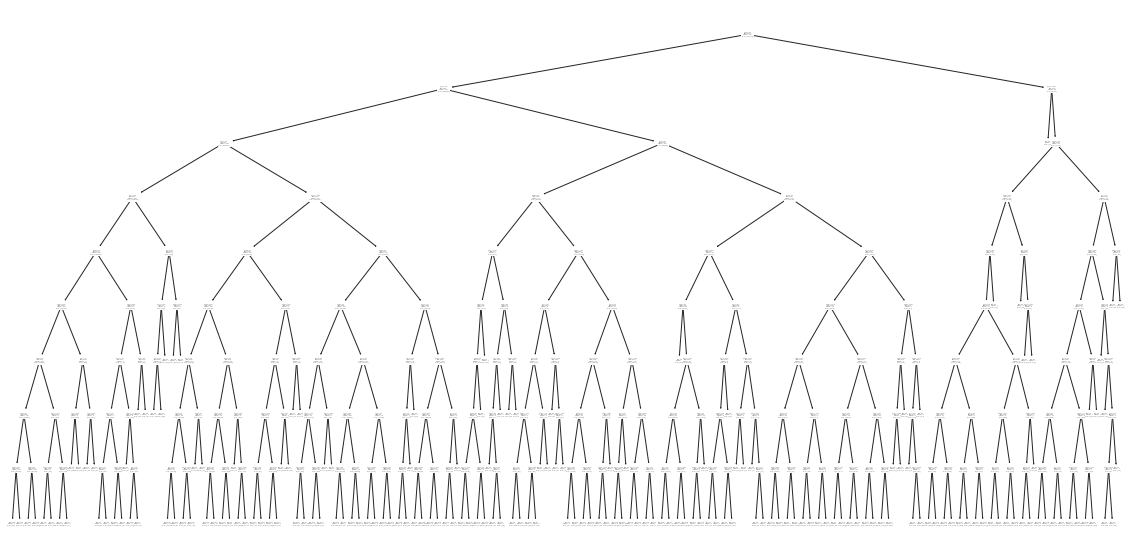

In [36]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(dtc, ax=ax)
plt.show()


###**Cross Validation Decision Tree Classifier**

In [37]:
# Cross validate our Decision Tree Classifier
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(dtc, X_test, y_test, cv=15)

In [38]:
from sklearn.metrics import accuracy_score
dtc.fit(X_test, y_test)
print ("Decision Tree Classifier accuracy is %2.2f" % accuracy_score(y_test, y_train_pred))

Decision Tree Classifier accuracy is 0.66


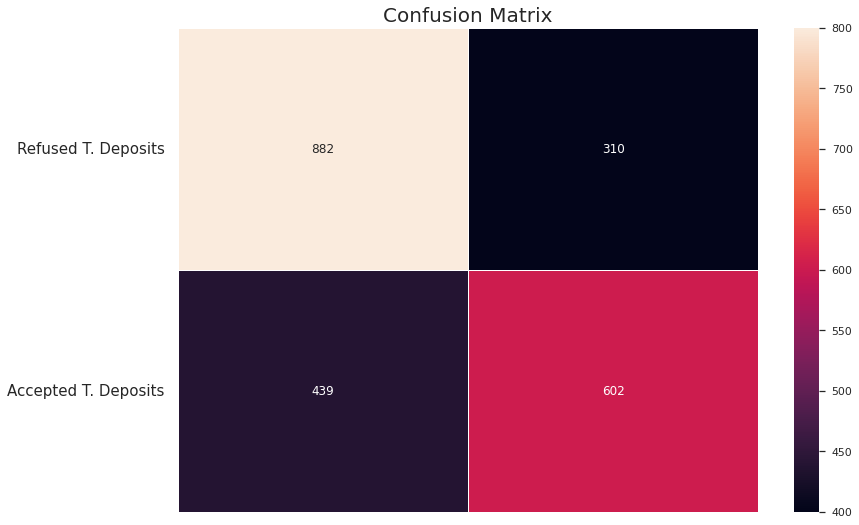

In [39]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_train_pred)
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(conf_matrix, vmin=400, vmax=800, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Confusion Matrix", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels("")
ax.set_yticklabels(['Refused T. Deposits', 'Accepted T. Deposits'], fontsize=15, rotation=360)
plt.show()

##**Naive Bayes**

#### Tuning Hyperparameter with GridSearchCV

We will use `GridSearchCV` functionality from sklearn to find the optimal parameter for our model.

In [40]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}


# Create a base model
rf_grids = GaussianNB()

# Initiate the grid search model
grid_search = GridSearchCV(rf_grids, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'var_smoothing': 1e-09}

### Building Model

In [41]:
from sklearn.naive_bayes import GaussianNB

# Building Naive Bayes model 
nb = GaussianNB(var_smoothing= 1e-09)
nb.fit(X_train, y_train)

GaussianNB()

### Model Evaluation

In [42]:
# Evaluate Model
nb_eval = evaluate_model(nb, X_test, y_test)

# Print result
print('Accuracy:', nb_eval['acc'])
print('Precision:', nb_eval['prec'])
print('Recall:', nb_eval['rec'])
print('F1 Score:', nb_eval['f1'])
print('Area Under Curve:', nb_eval['auc'])
print('Confusion Matrix:\n', nb_eval['cm'])

Accuracy: 0.6860725481415136
Precision: 0.7407932011331445
Recall: 0.5024015369836695
F1 Score: 0.5987406983400114
Area Under Curve: 0.7370671592235138
Confusion Matrix:
 [[1009  183]
 [ 518  523]]



###**Cross Validation Naive Bayes Classifier**

In [43]:
# Cross validate our Naive BayesClassifier
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(nb, X_test, y_test, cv=15)

In [44]:
from sklearn.metrics import accuracy_score
dtc.fit(X_test, y_test)
print ("Decision Tree Classifier accuracy is %2.2f" % accuracy_score(y_test, y_train_pred))

Decision Tree Classifier accuracy is 0.69


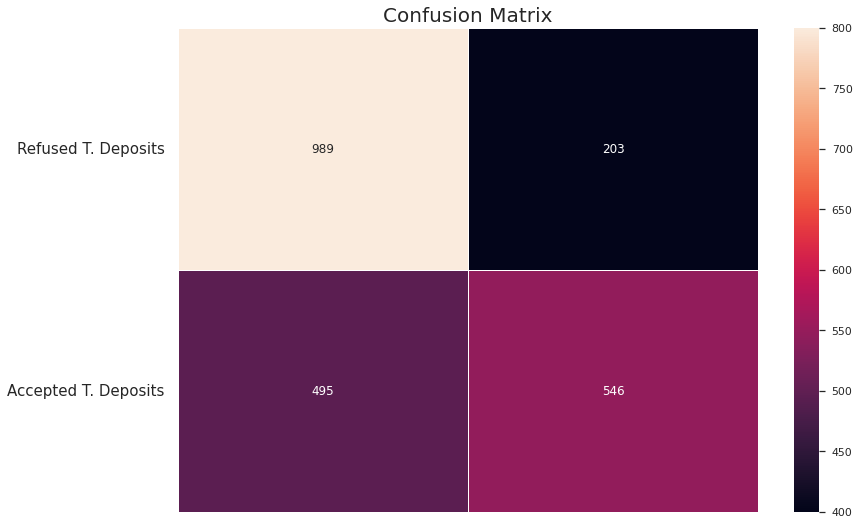

In [45]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_train_pred)
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(conf_matrix, vmin=400, vmax=800, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Confusion Matrix", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels("")
ax.set_yticklabels(['Refused T. Deposits', 'Accepted T. Deposits'], fontsize=15, rotation=360)
plt.show()

## **K-Nearest Neighbors**

#### Tuning Hyperparameter with GridSearchCV

We will use `GridSearchCV` functionality from sklearn to find the optimal parameter for our model.

In [46]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {'n_neighbors': [1, 3, 5, 7, 9], 'weights': ['uniform', 'distance']}


# Create a base model
rf_grids = KNeighborsClassifier()

# Initiate the grid search model
grid_search = GridSearchCV(rf_grids, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'n_neighbors': 9, 'weights': 'uniform'}

### Building Model

In [47]:
from sklearn.neighbors import KNeighborsClassifier

# Building KNN model 
knn = KNeighborsClassifier(n_neighbors= 9, weights='uniform')
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

### Model Evaluation

In [48]:
# Evaluate Model
knn_eval = evaluate_model(knn, X_test, y_test)

# Print result
print('Accuracy:', knn_eval['acc'])
print('Precision:', knn_eval['prec'])
print('Recall:', knn_eval['rec'])
print('F1 Score:', knn_eval['f1'])
print('Area Under Curve:', knn_eval['auc'])
print('Confusion Matrix:\n', knn_eval['cm'])

Accuracy: 0.690550828481863
Precision: 0.6966292134831461
Recall: 0.595581171950048
F1 Score: 0.6421543241843604
Area Under Curve: 0.7426418679767132
Confusion Matrix:
 [[922 270]
 [421 620]]



###**Cross Validation KNN Classifier**

In [49]:
# Cross validate our KNN Classifier
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(knn, X_test, y_test, cv=18)

In [50]:
from sklearn.metrics import accuracy_score
knn.fit(X_test, y_test)
print ("K-nearest Neighbor Classifier accuracy is %2.2f" % accuracy_score(y_test, y_train_pred))

K-nearest Neighbor Classifier accuracy is 0.68


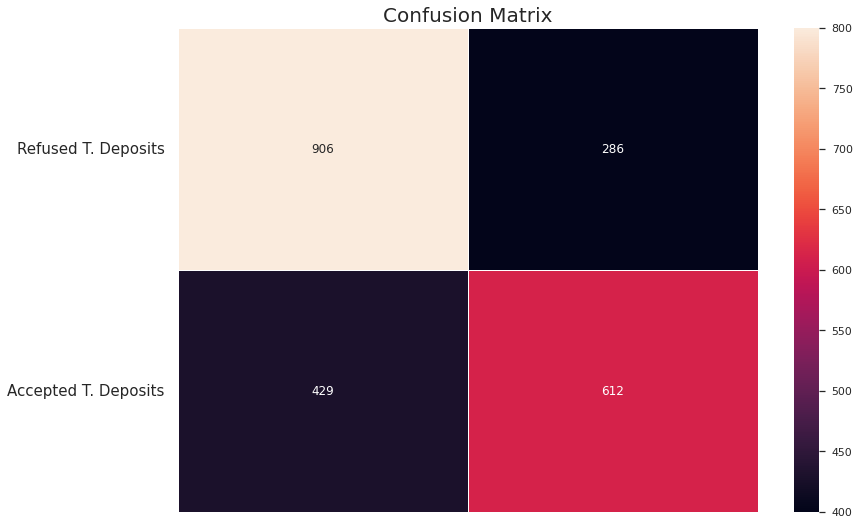

In [51]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_train_pred)
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(conf_matrix, vmin=400, vmax=800, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Confusion Matrix", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels("")
ax.set_yticklabels(['Refused T. Deposits', 'Accepted T. Deposits'], fontsize=15, rotation=360)
plt.show()



```
After Cross validation
model seems to have less accuracy to predict than before cross validation
```



## Model Comparison


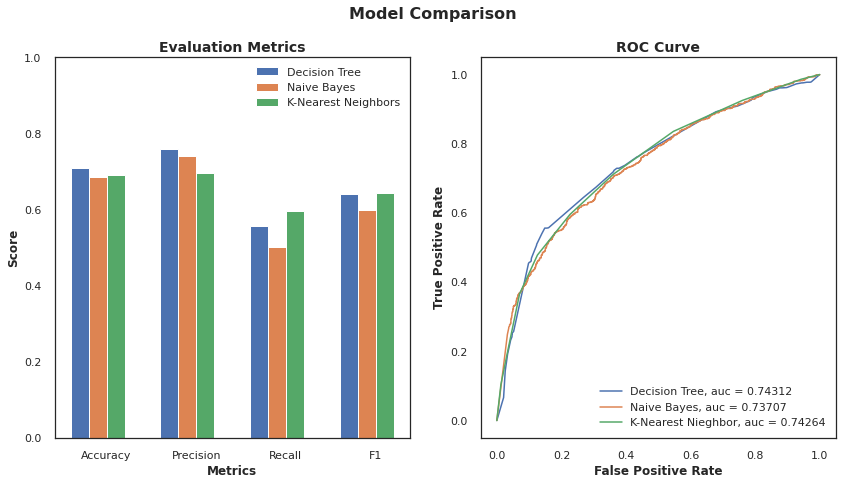

In [52]:
# Intitialize figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(14)
fig.set_facecolor('white')

# First plot
## set bar size
barWidth = 0.2
dtc_score = [dtc_eval['acc'], dtc_eval['prec'], dtc_eval['rec'], dtc_eval['f1']]
nb_score = [nb_eval['acc'], nb_eval['prec'], nb_eval['rec'], nb_eval['f1']]
knn_score = [knn_eval['acc'], knn_eval['prec'], knn_eval['rec'], knn_eval['f1']]

## Set position of bar on X axis
r1 = np.arange(len(dtc_score))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]


## Make the plot
ax1.bar(r1, dtc_score, width=barWidth, edgecolor='white', label='Decision Tree')
ax1.bar(r2, nb_score, width=barWidth, edgecolor='white', label='Naive Bayes')
ax1.bar(r3, knn_score, width=barWidth, edgecolor='white', label='K-Nearest Neighbors')

## Configure x and y axis
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1']
ax1.set_xticks([r + (barWidth * 1.5) for r in range(len(dtc_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_ylim(0, 1)

## Create legend & title
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

# Second plot
## Comparing ROC Curve
ax2.plot(dtc_eval['fpr'], dtc_eval['tpr'], label='Decision Tree, auc = {:0.5f}'.format(dtc_eval['auc']))
ax2.plot(nb_eval['fpr'], nb_eval['tpr'], label='Naive Bayes, auc = {:0.5f}'.format(nb_eval['auc']))
ax2.plot(knn_eval['fpr'], knn_eval['tpr'], label='K-Nearest Nieghbor, auc = {:0.5f}'.format(knn_eval['auc']))

## Configure x and y axis
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')

## Create legend & title
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(loc=4)

plt.show()

#**Decision Tree Winning!**
From the figures above we can see that our Decision Tree model tops the other models. So we can assume that Decision Tree is the right choice to solve our problem.

## Prediction

we will predict the expected outcome of all the row from our dataset with **Decision Tree Model**

In [53]:
df_bank['deposit_prediction'] = nb.predict(feature)
df_bank['deposit_prediction'] = df_bank['deposit_prediction'].apply(lambda x: 'yes' if x==0 else 'no')

# Save new dataframe into csv file
df_bank.to_csv('deposit_prediction.csv', index=False)

df_bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit,deposit_prediction
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1,-1,0,unknown,yes,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1,-1,0,unknown,yes,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1,-1,0,unknown,yes,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,1,-1,0,unknown,yes,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,2,-1,0,unknown,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,1,-1,0,unknown,no,yes
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,4,-1,0,unknown,no,yes
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,2,-1,0,unknown,no,yes
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,2,172,5,failure,no,yes


#**Manual Clustering**

```
- Marital Status: the impact of a divorce has a significant impact on the balance of the individual.

- Education: The level of education also has a significant impact on the amount of balance a prospect has.

- Loans: Whether the prospect has a previous loan has a significant impact on the amount of balance them has.
```





```
เอาไว้ดูว่า กลุ่มคนต่างระดับการศึกษาต่างสถานภาพ จะมียอดเงินคงเหลือในบัญชีมากน้อยเพียงใด
```



In [54]:
df = df.drop(df.loc[df["education"] == "unknown"].index)
df['education'].unique()

array(['secondary', 'tertiary', 'primary'], dtype=object)

In [55]:
df['marital/education'] = np.nan
lst = [df]

for col in lst:
    col.loc[(col['marital'] == 'single') & (df['education'] == 'primary'), 'marital/education'] = 'single/primary'
    col.loc[(col['marital'] == 'married') & (df['education'] == 'primary'), 'marital/education'] = 'married/primary'
    col.loc[(col['marital'] == 'divorced') & (df['education'] == 'primary'), 'marital/education'] = 'divorced/primary'
    col.loc[(col['marital'] == 'single') & (df['education'] == 'secondary'), 'marital/education'] = 'single/secondary'
    col.loc[(col['marital'] == 'married') & (df['education'] == 'secondary'), 'marital/education'] = 'married/secondary'
    col.loc[(col['marital'] == 'divorced') & (df['education'] == 'secondary'), 'marital/education'] = 'divorced/secondary'
    col.loc[(col['marital'] == 'single') & (df['education'] == 'tertiary'), 'marital/education'] = 'single/tertiary'
    col.loc[(col['marital'] == 'married') & (df['education'] == 'tertiary'), 'marital/education'] = 'married/tertiary'
    col.loc[(col['marital'] == 'divorced') & (df['education'] == 'tertiary'), 'marital/education'] = 'divorced/tertiary'
    
    
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,marital/education
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,married/secondary
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,married/secondary
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,married/secondary
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,married/secondary
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes,married/tertiary


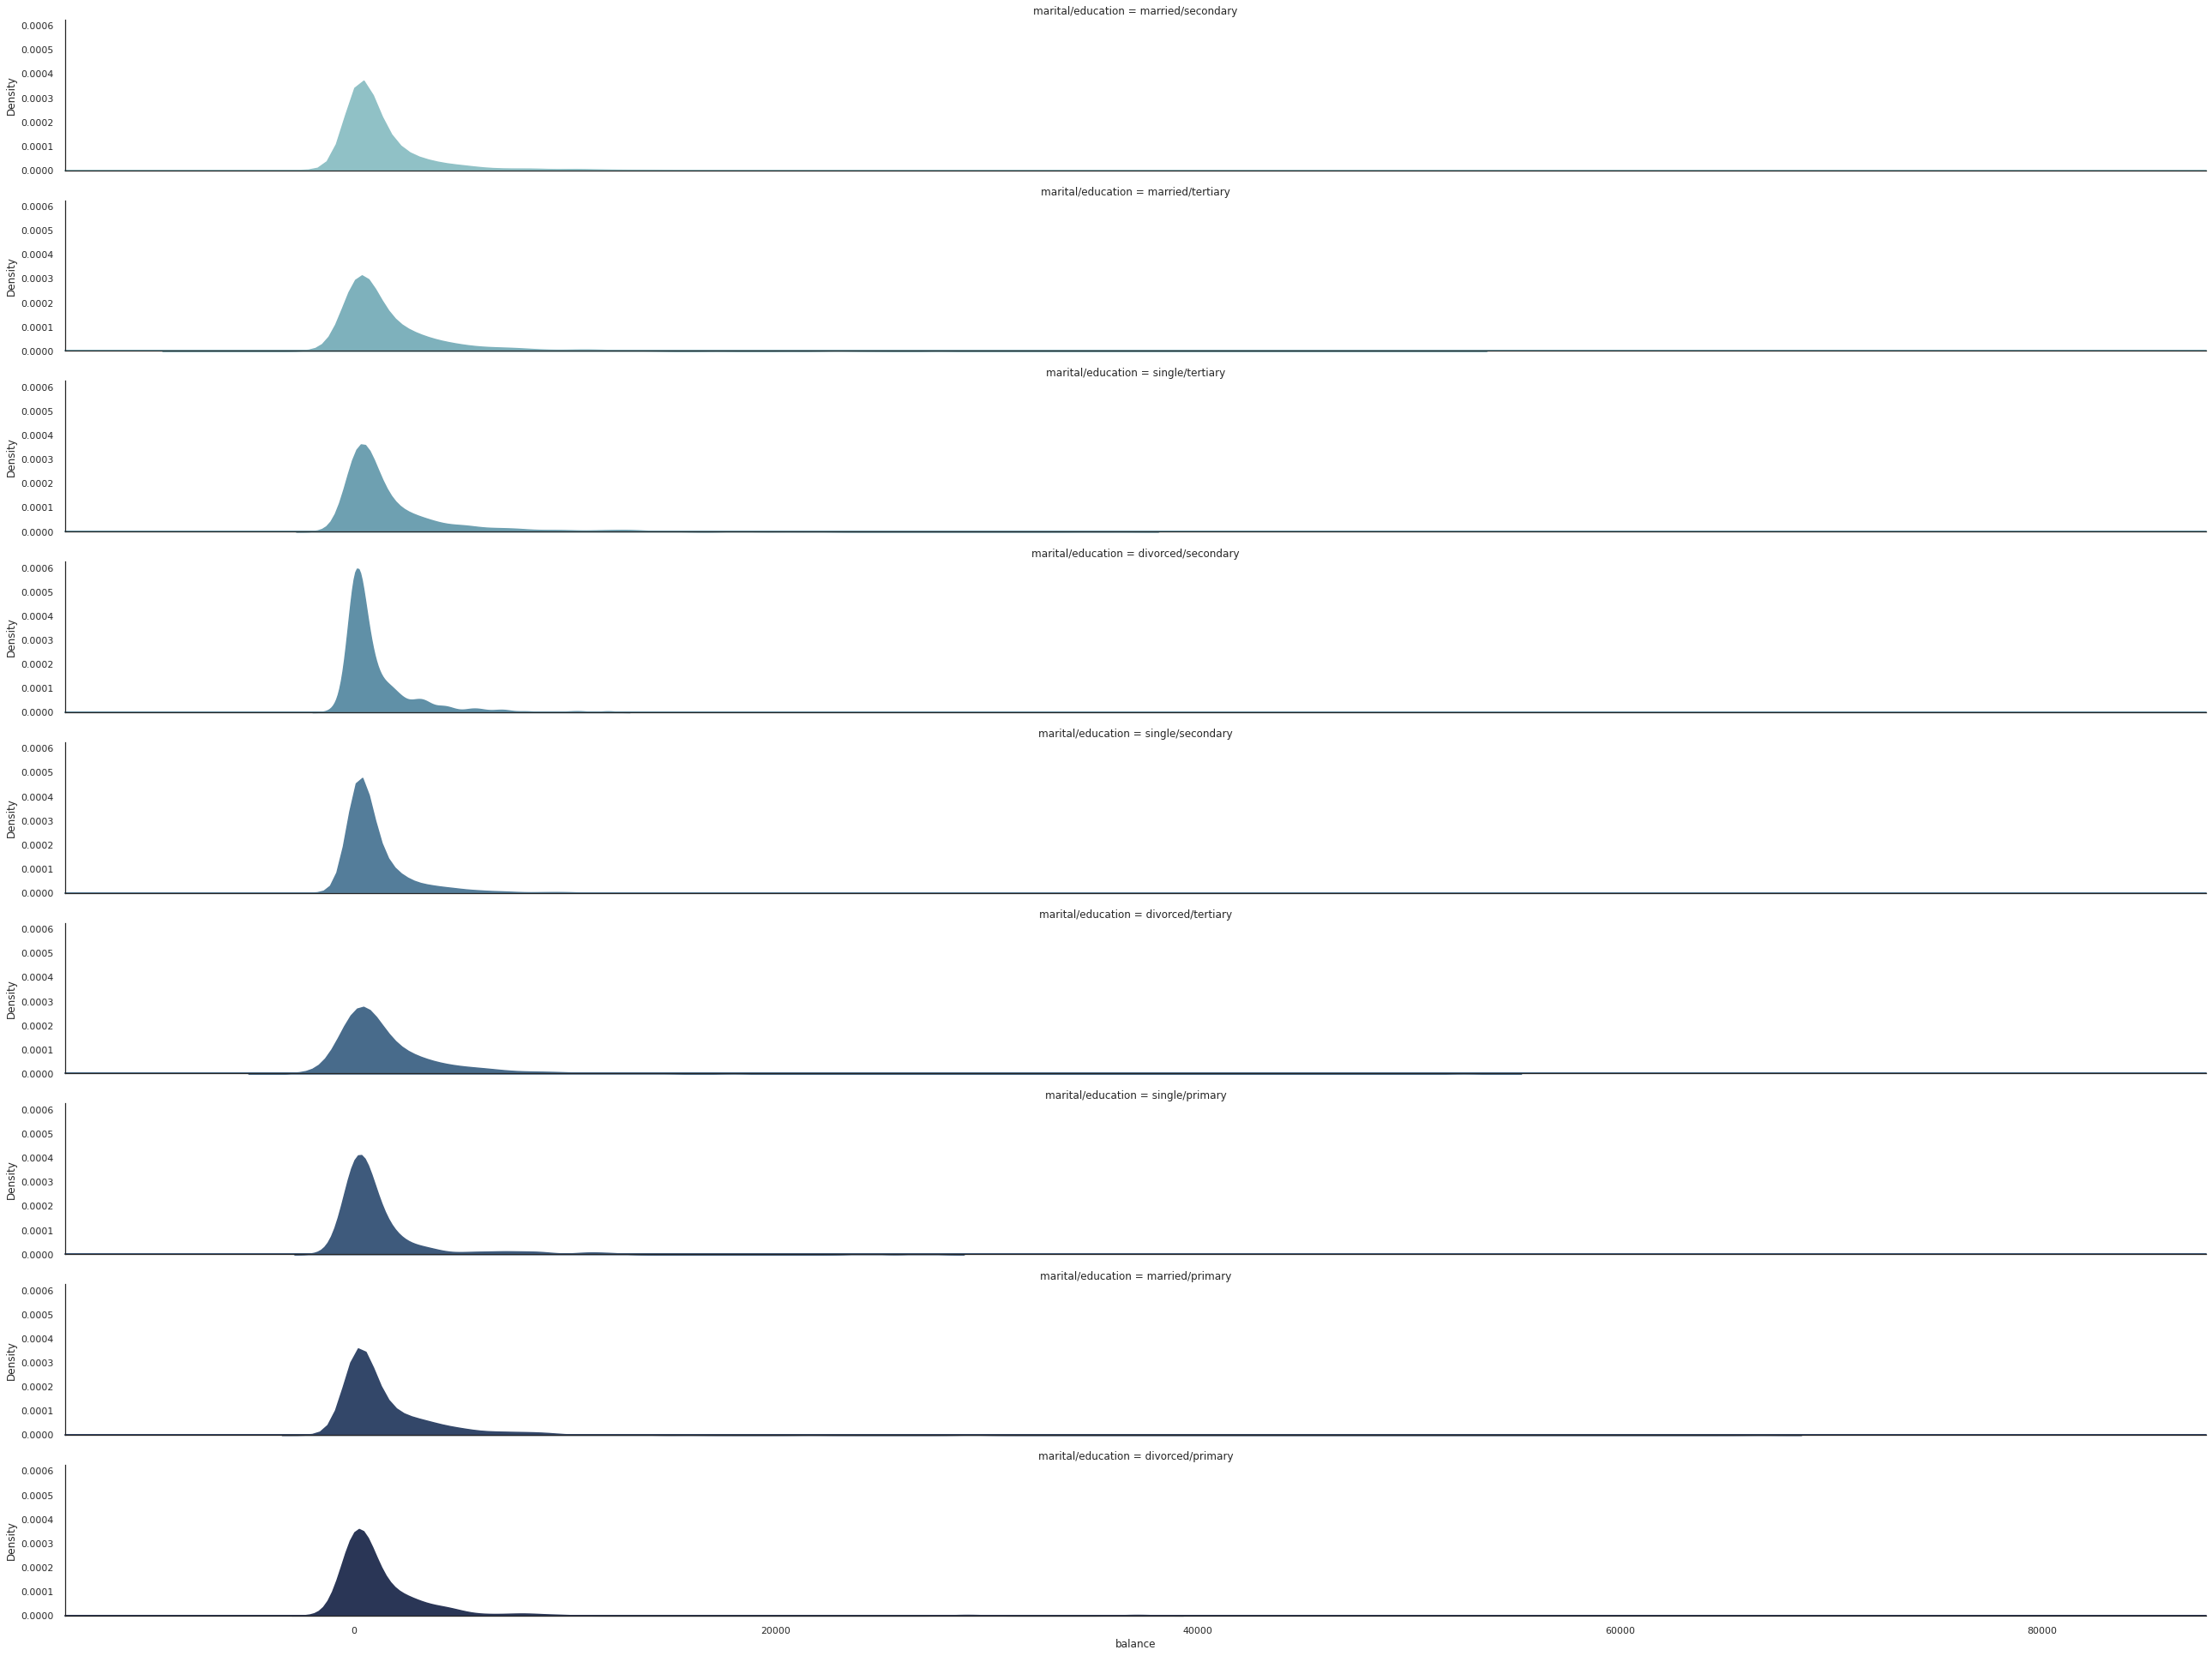

In [56]:
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="marital/education", hue="marital/education", aspect=12, palette=pal)

g.map(sns.kdeplot, "balance", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "balance", clip_on=False, color="w", lw=1, bw=0)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

Text(0.5, 1.0, 'Median Balance by Educational/Marital Group')

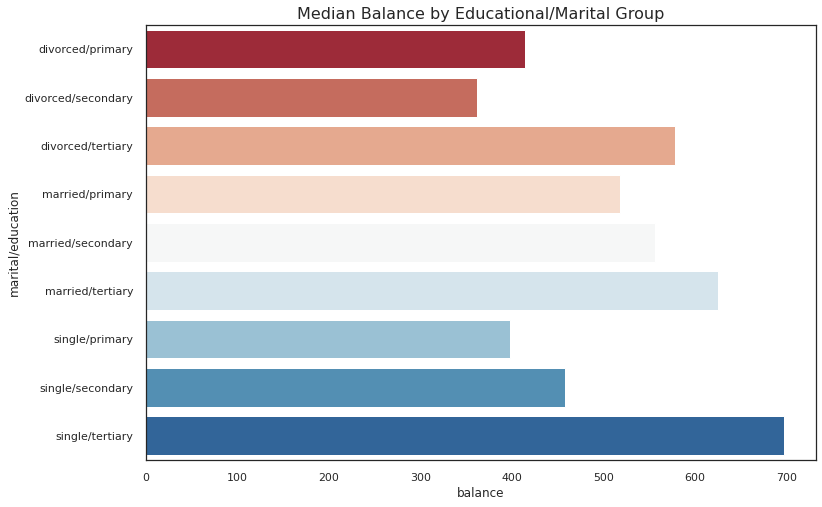

In [57]:
education_groups = df.groupby(['marital/education'], as_index=False)['balance'].median()

fig = plt.figure(figsize=(12,8))




sns.barplot(x="balance", y="marital/education", data=education_groups,
            label="Total", palette="RdBu")

plt.title('Median Balance by Educational/Marital Group', fontsize=16)

In [58]:
# Let's see the group who had loans from the marital/education group

loan_balance = df.groupby(['marital/education', 'loan'], as_index=False)['balance'].median()


no_loan = loan_balance['balance'].loc[loan_balance['loan'] == 'no'].values
has_loan = loan_balance['balance'].loc[loan_balance['loan'] == 'yes'].values


labels = loan_balance['marital/education'].unique().tolist()


trace0 = go.Scatter(
    x=no_loan,
    y=labels,
    mode='markers',
    name='No Loan',
    marker=dict(
        color='rgb(175,238,238)',
        line=dict(
            color='rgb(0,139,139)',
            width=1,
        ),
        symbol='circle',
        size=16,
    )
)
trace1 = go.Scatter(
    x=has_loan,
    y=labels,
    mode='markers',
    name='Has a Previous Loan',
    marker=dict(
        color='rgb(250,128,114)',
        line=dict(
            color='rgb(178,34,34)',
            width=1,
        ),
        symbol='circle',
        size=16,
    )
)

data = [trace0, trace1]
layout = go.Layout(
    title="The Impact of Loans to Married/Educational Clusters",
    xaxis=dict(
        showgrid=False,
        showline=True,
        linecolor='rgb(102, 102, 102)',
        titlefont=dict(
            color='rgb(204, 204, 204)'
        ),
        tickfont=dict(
            color='rgb(102, 102, 102)',
        ),
        showticklabels=False,
        dtick=10,
        ticks='outside',
        tickcolor='rgb(102, 102, 102)',
    ),
    margin=dict(
        l=140,
        r=40,
        b=50,
        t=80
    ),
    legend=dict(
        font=dict(
            size=10,
        ),
        yanchor='middle',
        xanchor='right',
    ),
    width=1000,
    height=800,
    paper_bgcolor='rgb(255,250,250)',
    plot_bgcolor='rgb(255,255,255)',
    hovermode='closest',
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='lowest-oecd-votes-cast')

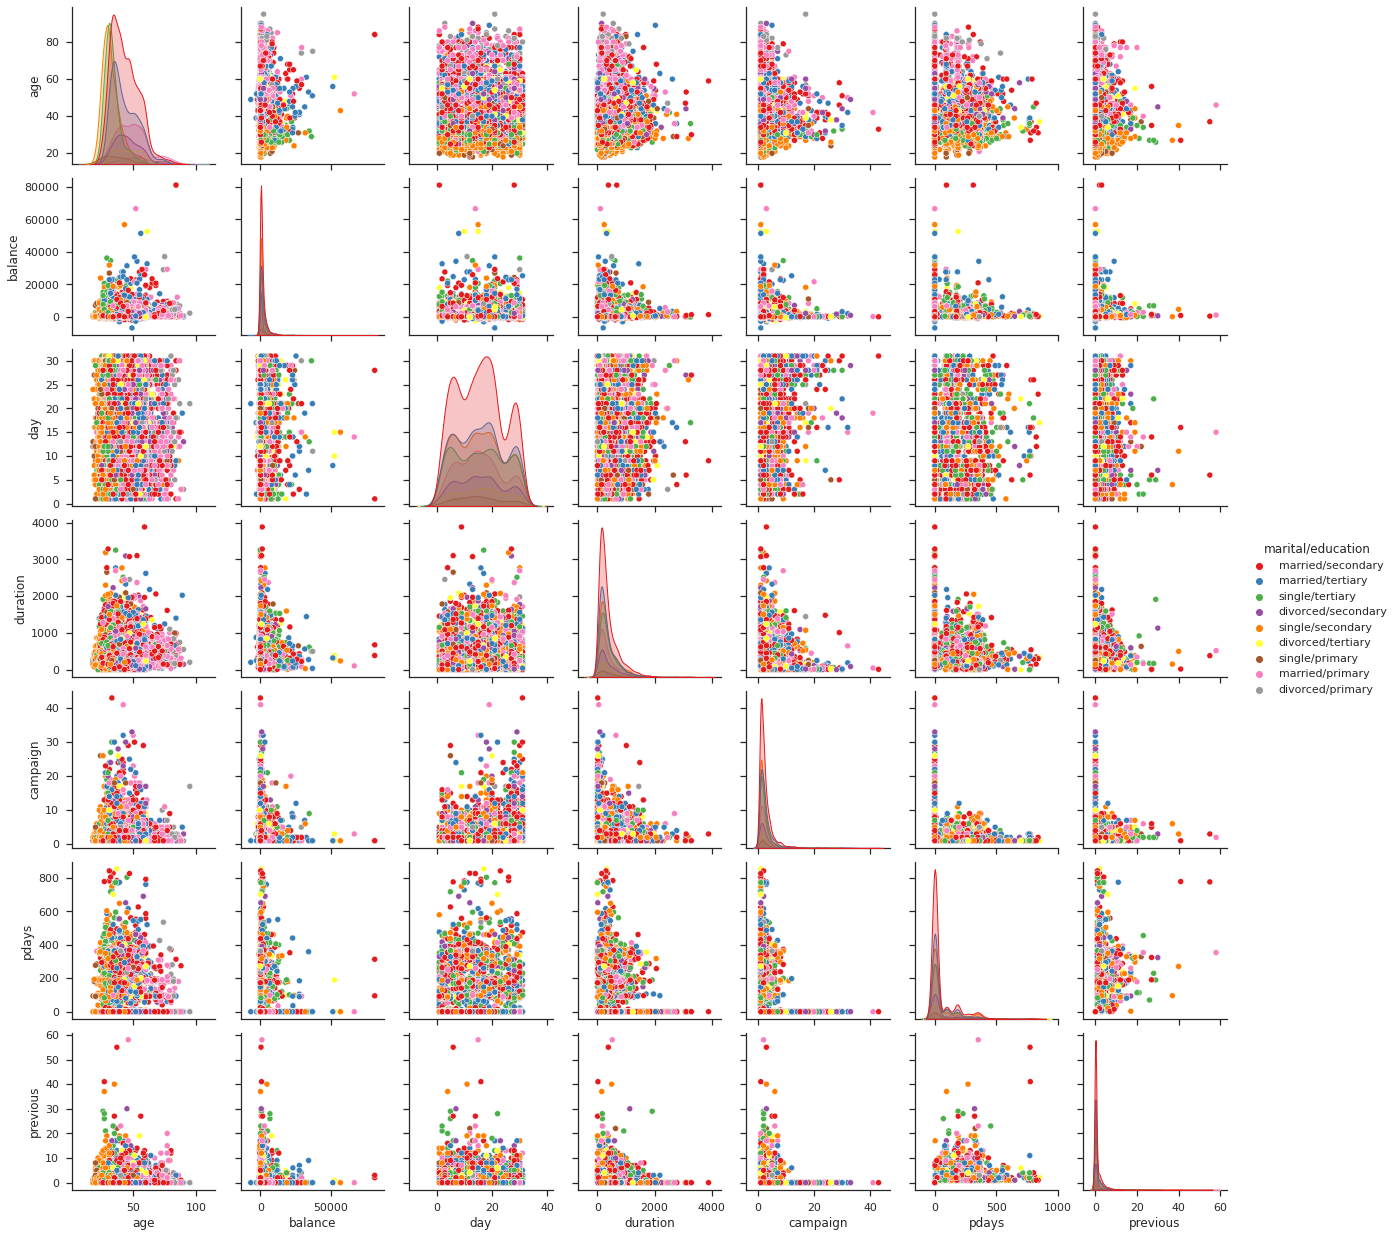

In [59]:
import seaborn as sns
sns.set(style="ticks")

sns.pairplot(df, hue="marital/education", palette="Set1")
plt.show()

##**K mean Clustering**



```
ใช้ plot elbrow หา suitable Number of Cluster
```



In [60]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.decomposition import FastICA
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import silhouette_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score, precision_score, recall_score,f1_score
from sklearn.metrics import make_scorer, accuracy_score

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline

In [61]:
data = pd.read_csv('/content/drive/MyDrive/DPDM/Project/bank.csv')

In [62]:
data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


Text(0.5, 1.0, 'Variable Correlation')

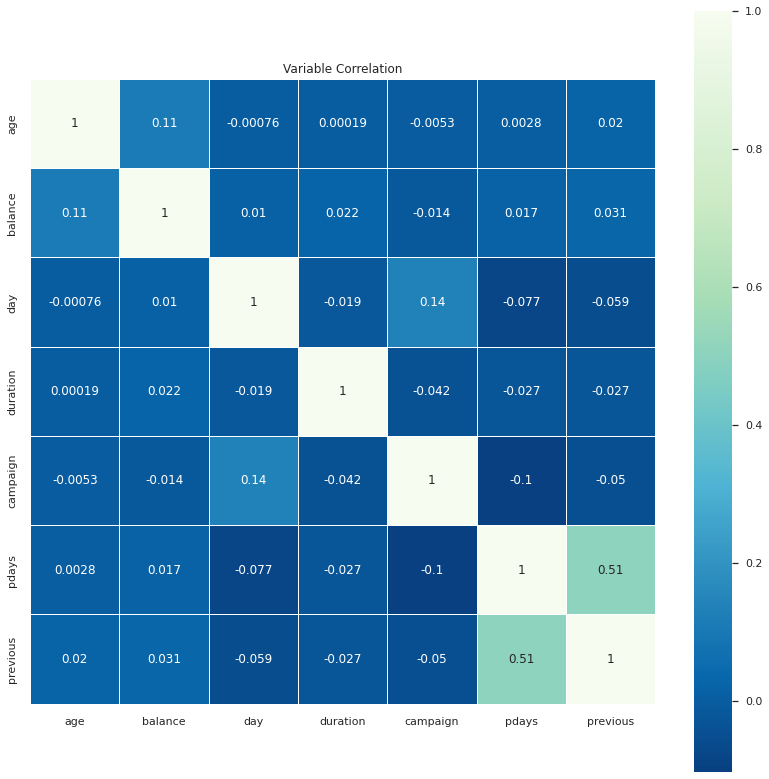

In [63]:
#Correlation Plot
plt.figure(figsize=(14,14))
sns.set(font_scale=1)
sns.heatmap(data.corr(),cmap='GnBu_r',annot=True, square = True ,linewidths=.5);
plt.title('Variable Correlation')

In [64]:
#label encoding

jobDummies = pd.get_dummies(data['job'], prefix = 'job')
maritalDummies = pd.get_dummies(data['marital'], prefix = 'marital')
educationDummies = pd.get_dummies(data['education'], prefix = 'education')
defaultDummies = pd.get_dummies(data['default'], prefix = 'default')
housingDummies = pd.get_dummies(data['housing'], prefix = 'housing')
loanDummies = pd.get_dummies(data['loan'], prefix = 'loan')
contactDummies = pd.get_dummies(data['contact'], prefix = 'contact')
poutcomeDummies = pd.get_dummies(data['poutcome'], prefix = 'poutcome')
data['month']=data['month'].astype('category')
data['day']=data['day'].astype('category')
data['deposit']=data['deposit'].astype('category')
# Assigning numerical values and storing in another column
data['month'] = data['month'].cat.codes
data['day'] = data['day'].cat.codes
data['deposit'] = data['deposit'].cat.codes

In [65]:
data["age"]=data["age"].astype("int")
data["duration"]=data["duration"].astype("int")
data["pdays"]=data["pdays"].astype("int")
data["previous"]=data["previous"].astype("int")
data["campaign"]=data["campaign"].astype("int")
data_int=data.select_dtypes(include=['int','float64','bool'])
#data_int
bank_df=pd.concat([data_int,jobDummies,maritalDummies,educationDummies,defaultDummies,housingDummies,loanDummies
                  ,contactDummies,poutcomeDummies,data['month'],data['day'],data['deposit']],axis=1)

In [66]:
bank_df

,age,balance,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,month,day,deposit
0,59,2343,1042,1,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,8,4,1
1,56,45,1467,1,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,8,4,1
2,41,1270,1389,1,-1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,8,4,1
3,55,2476,579,1,-1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,8,4,1
4,54,184,673,2,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,1,8,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,1,257,1,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,19,0
11158,39,733,83,4,-1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,6,15,0
11159,32,29,156,2,-1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,1,1,18,0
11160,43,0,9,2,172,5,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0,0,8,7,0


In [67]:
#Predictors count
bank_df.groupby('deposit').size()

deposit
0    5873
1    5289
dtype: int64

In [68]:
#Total features after one-hot-encoding
features = bank_df.columns
len(features)

41

In [69]:
#Variables and Output
y=np.array(bank_df["deposit"])
X=np.array(bank_df.iloc[:,0:40])

In [70]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

In [71]:
#kmeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

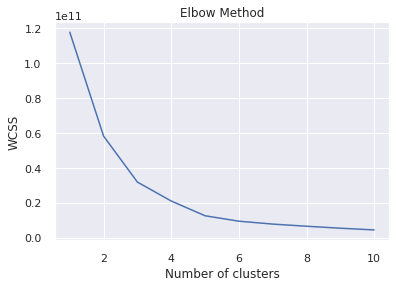

In [72]:
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [73]:
#kmeans
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

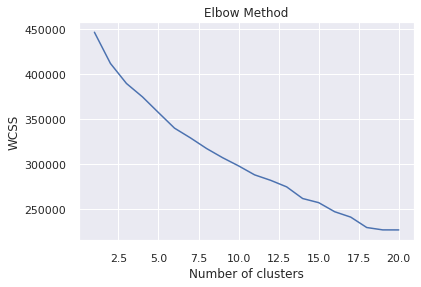

In [74]:
plt.plot(range(1, 21), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

##**Cluster N = 2**

In [75]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)


bank_df['clusters1'] = pred_y

bank_df.clusters1.unique()
bank_df['clusters1'].value_counts()

0    10698
1      464
Name: clusters1, dtype: int64

In [76]:
matrix = confusion_matrix(y, bank_df['clusters1'])
print(matrix)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y, bank_df['clusters1'])
print('Accuracy: %f' % accuracy)
#precision tp / (tp + fp)
precision = precision_score(y, bank_df['clusters1'])
print('Precision: %f' % precision)

[[5675  198]
 [5023  266]]
Accuracy: 0.532252
Precision: 0.573276


In [77]:
s = silhouette_score(X, kmeans.labels_)
print('Silhouette Score:', s)

Silhouette Score: 0.8347883857207805


##**Cluster N=3**

In [78]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)


bank_df['clusters2'] = pred_y

bank_df.clusters2.unique()
bank_df['clusters2'].value_counts()

0    9870
2    1215
1      77
Name: clusters2, dtype: int64

In [79]:
s = silhouette_score(X, kmeans.labels_)
print('Silhouette Score:', s)

Silhouette Score: 0.7425546511131831


## K mode Clustering

In [106]:
data = pd.read_csv('/content/drive/MyDrive/DPDM/Project/bank.csv')
bank_cust = data[['age','job', 'marital', 'education', 'default', 'housing', 'loan','contact','month','day','poutcome','deposit']]
bank_cust.head()

,age,job,marital,education,default,housing,loan,contact,month,day,poutcome,deposit
0,59,admin.,married,secondary,no,yes,no,unknown,may,5,unknown,yes
1,56,admin.,married,secondary,no,no,no,unknown,may,5,unknown,yes
2,41,technician,married,secondary,no,yes,no,unknown,may,5,unknown,yes
3,55,services,married,secondary,no,yes,no,unknown,may,5,unknown,yes
4,54,admin.,married,tertiary,no,no,no,unknown,may,5,unknown,yes


In [107]:
bank_cust['age_cat'] = pd.cut(bank_cust['age'], [0, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                              labels=['0-20', '20-30', '30-40', '40-50','50-60','60-70','70-80', '80-90','90-100'])

In [108]:
bank_cust

,age,job,marital,education,default,housing,loan,contact,month,day,poutcome,deposit,age_cat
0,59,admin.,married,secondary,no,yes,no,unknown,may,5,unknown,yes,50-60
1,56,admin.,married,secondary,no,no,no,unknown,may,5,unknown,yes,50-60
2,41,technician,married,secondary,no,yes,no,unknown,may,5,unknown,yes,40-50
3,55,services,married,secondary,no,yes,no,unknown,may,5,unknown,yes,50-60
4,54,admin.,married,tertiary,no,no,no,unknown,may,5,unknown,yes,50-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,yes,no,cellular,apr,20,unknown,no,30-40
11158,39,services,married,secondary,no,no,no,unknown,jun,16,unknown,no,30-40
11159,32,technician,single,secondary,no,no,no,cellular,aug,19,unknown,no,30-40
11160,43,technician,married,secondary,no,no,yes,cellular,may,8,failure,no,40-50


In [109]:
bank_cust  = bank_cust.drop('age',axis = 1)

In [110]:
bank_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   job        11162 non-null  object  
 1   marital    11162 non-null  object  
 2   education  11162 non-null  object  
 3   default    11162 non-null  object  
 4   housing    11162 non-null  object  
 5   loan       11162 non-null  object  
 6   contact    11162 non-null  object  
 7   month      11162 non-null  object  
 8   day        11162 non-null  int64   
 9   poutcome   11162 non-null  object  
 10  deposit    11162 non-null  object  
 11  age_cat    11162 non-null  category
dtypes: category(1), int64(1), object(10)
memory usage: 970.6+ KB


In [111]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
bank_cust = bank_cust.apply(le.fit_transform)
bank_cust.head()

,job,marital,education,default,housing,loan,contact,month,day,poutcome,deposit,age_cat
0,0,1,1,0,1,0,2,8,4,3,1,4
1,0,1,1,0,0,0,2,8,4,3,1,4
2,9,1,1,0,1,0,2,8,4,3,1,3
3,7,1,1,0,1,0,2,8,4,3,1,4
4,0,1,2,0,0,0,2,8,4,3,1,4


In [112]:
# Checking the count per category
job_df = pd.DataFrame(bank_cust['job'].value_counts())
job_df.head()

,job
4,2566
1,1944
9,1823
0,1334
7,923


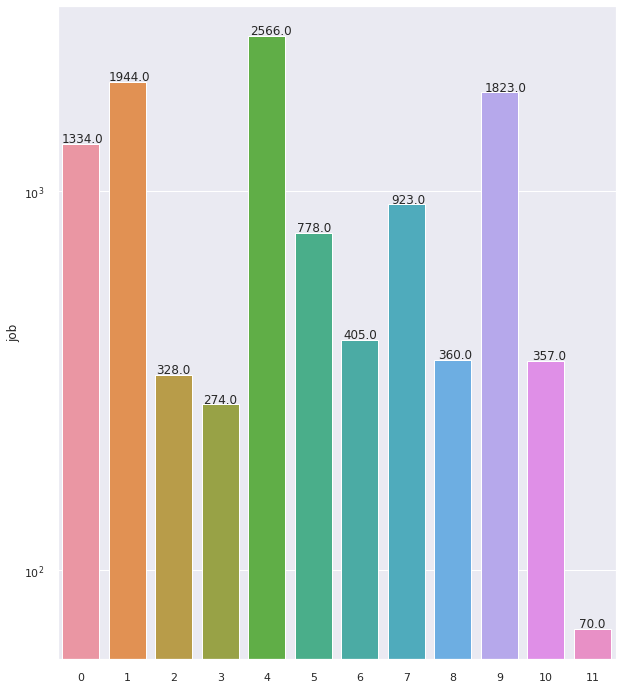

In [113]:
plt.figure(figsize=(10, 12))
ax=sns.barplot(x=job_df.index, y=job_df['job'])
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))
ax.set_yscale('log')
plt.show()

In [114]:
# Checking the count per category
age_df = pd.DataFrame(bank_cust['age_cat'].value_counts())
age_df.head()

,age_cat
2,4188
3,2496
1,1966
4,1860
5,338


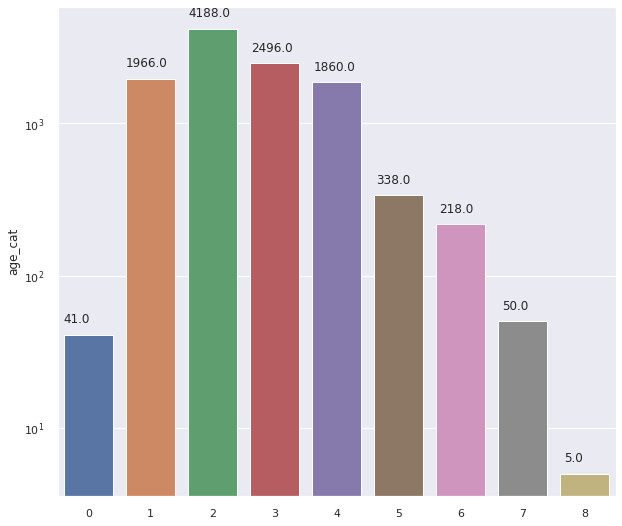

In [115]:
plt.figure(figsize=(10, 9))
ax=sns.barplot(x=age_df.index, y=age_df['age_cat'])
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.2))
ax.set_yscale('log')
plt.show()

In [116]:
pip install kmodes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [117]:
from kmodes.kmodes import KModes

In [118]:
km_cao = KModes(n_clusters=2, init = "Cao", n_init = 1, verbose=1)
fitClusters_cao = km_cao.fit_predict(bank_cust)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1404, cost: 54890.0
Run 1, iteration: 2/100, moves: 88, cost: 54890.0


In [119]:
# Predicted Clusters
fitClusters_cao

array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

In [120]:
clusterCentroidsDf = pd.DataFrame(km_cao.cluster_centroids_)
clusterCentroidsDf.columns = bank_cust.columns

In [121]:
# Mode of the clusters
clusterCentroidsDf

,job,marital,education,default,housing,loan,contact,month,day,poutcome,deposit,age_cat
0,1,1,1,0,1,0,0,8,17,3,0,2
1,4,2,2,0,0,0,0,5,29,3,1,1


In [122]:
bank_cust = bank_cust.reset_index()
clustersDf = pd.DataFrame(fitClusters_cao)
clustersDf.columns = ['cluster_predicted']
combinedDf = pd.concat([bank_cust, clustersDf], axis = 1).reset_index()
combinedDf = combinedDf.drop(['index', 'level_0'], axis = 1)

In [123]:
combinedDf

,job,marital,education,default,housing,loan,contact,month,day,poutcome,deposit,age_cat,cluster_predicted
0,0,1,1,0,1,0,2,8,4,3,1,4,0
1,0,1,1,0,0,0,2,8,4,3,1,4,0
2,9,1,1,0,1,0,2,8,4,3,1,3,0
3,7,1,1,0,1,0,2,8,4,3,1,4,0
4,0,1,2,0,0,0,2,8,4,3,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,1,2,0,0,1,0,0,0,19,3,0,2,0
11158,7,1,1,0,0,0,2,6,15,3,0,2,0
11159,9,2,1,0,0,0,0,1,18,3,0,2,0
11160,9,1,1,0,0,1,0,8,7,0,0,3,0


In [124]:
# Data for Cluster0
cluster0 = combinedDf[combinedDf.cluster_predicted==0]
# Data for Cluster1
cluster1 = combinedDf[combinedDf.cluster_predicted==1]

In [125]:
job0_df = pd.DataFrame(cluster0['job'].value_counts())
job1_df = pd.DataFrame(cluster1['job'].value_counts())

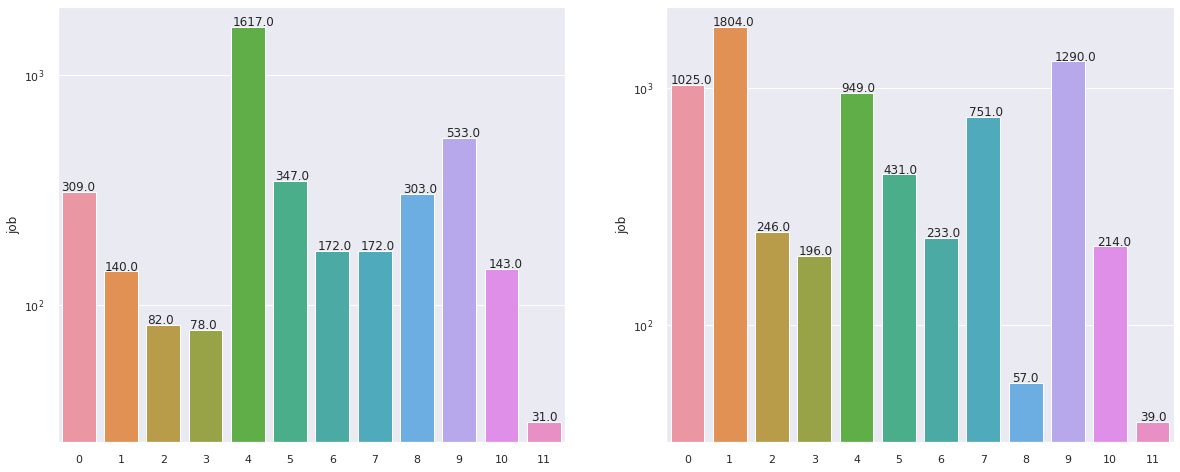

In [126]:
fig, ax =plt.subplots(1,2,figsize=(20,8))

a=sns.barplot(x=job1_df.index, y=job1_df['job'], ax=ax[0])
for p in a.patches:
    a.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))
a.set_yscale('log')
b=sns.barplot(x=job0_df.index, y=job0_df['job'], ax=ax[1])
for p in b.patches:
    b.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))
b.set_yscale('log')
fig.show()

In [127]:
age0_df = pd.DataFrame(cluster0['age_cat'].value_counts())
age1_df = pd.DataFrame(cluster1['age_cat'].value_counts())

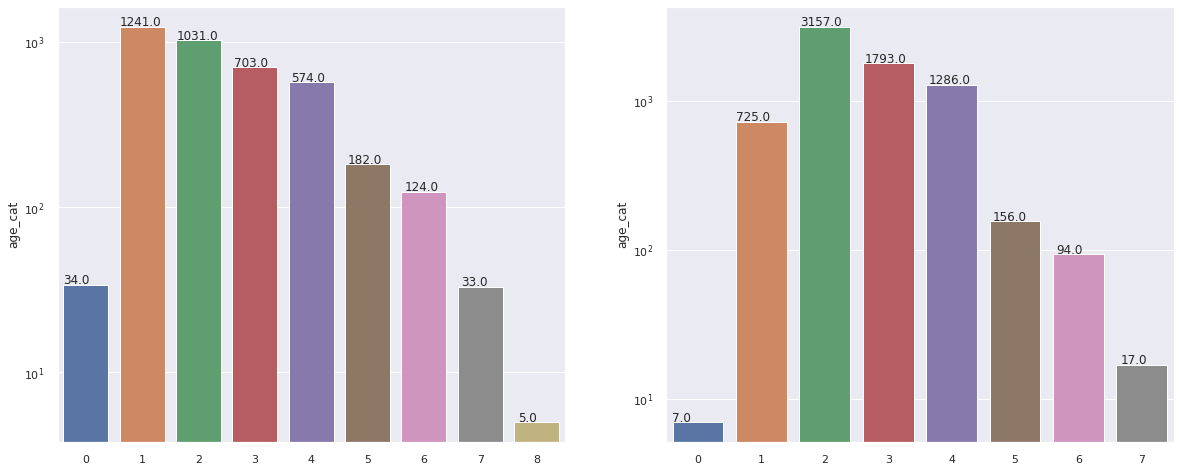

In [128]:
fig, ax =plt.subplots(1,2,figsize=(20,8))
a=sns.barplot(x=age1_df.index, y=age1_df['age_cat'], ax=ax[0])
for p in a.patches:
    a.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))
a.set_yscale('log')
b=sns.barplot(x=age0_df.index, y=age0_df['age_cat'], ax=ax[1])
for p in b.patches:
    b.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))
b.set_yscale('log')
fig.show()

In [129]:
cluster1['marital'].value_counts()

2    2100
1    1323
0     504
Name: marital, dtype: int64

In [130]:
cluster1['education'].value_counts()

2    2415
1     930
0     358
3     224
Name: education, dtype: int64

In [133]:
deposit0_df = pd.DataFrame(cluster0['deposit'].value_counts())
deposit1_df = pd.DataFrame(cluster1['deposit'].value_counts())

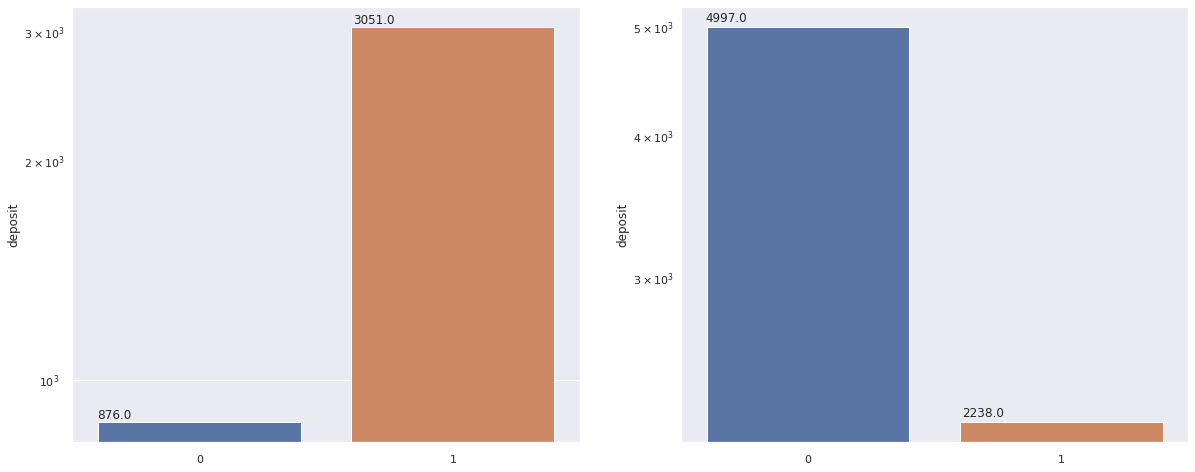

In [134]:
fig, ax =plt.subplots(1,2,figsize=(20,8))

a=sns.barplot(x=deposit1_df.index, y=deposit1_df['deposit'], ax=ax[0])
for p in a.patches:
    a.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))
a.set_yscale('log')
b=sns.barplot(x=deposit0_df.index, y=deposit0_df['deposit'], ax=ax[1])
for p in b.patches:
    b.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))
b.set_yscale('log')
fig.show()



```
As you can see from graph Cluster Deposit plot
Cluster 1 tends to have more Deposit=No more than Cluster 2

***So Our target is in the Cluster 2 because they have mora client that accept a termof deposit***
```



#**Association**

###Data Transformation
Preparing data for association rule mining

In [135]:
!pip install apyori

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5976 sha256=7c48c5fbff51d8678439cf1a1702e9ff5e7d0ed41028299a7b35ea4f483bd7db
  Stored in directory: /root/.cache/pip/wheels/32/2a/54/10c595515f385f3726642b10c60bf788029e8f3a1323e3913a
Successfully built apyori


Data Transaction

In [136]:
df_t = pd.read_csv('/content/drive/MyDrive/DPDM/Project/bank.csv')
df_t

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


**AGE**

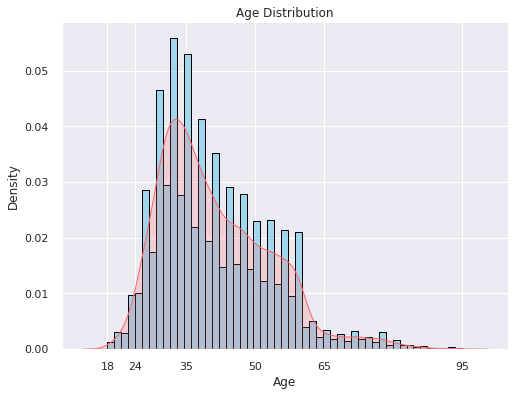

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load data into a Pandas dataframe
bank_data = pd.read_csv("/content/drive/MyDrive/DPDM/Project/bank.csv")

# Create a histogram of the age distribution with a density curve
plt.figure(figsize=(8, 6))
sns.histplot(bank_data, x="age", stat="density", color="skyblue", edgecolor="black", linewidth=1)
sns.kdeplot(bank_data["age"], color="#FF6666", alpha=.2, fill=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Density")
plt.xticks([18,24,35,50,65,95])
sns.despine()
plt.show()

In [138]:
# Create age groups
bank_data['age'] = pd.cut(bank_data['age'], bins=[18,24,35,50,65,float('inf')], labels=['youth', 'young_adult', 'middle_aged_adult', 'senior_age', 'old'], include_lowest=True)


- **DEFAULT**
- **HOUSING**
- **LOAN**
- **DEPOSIT**
```
The fields that contained “YES” or “NO” like 
‘Default’, ’housing’, ’loan’, ‘deposit’ was transformed to “variable name = variable name = YES/NO” 
so that it would be clear in the rules what attribute is related to the YES or NO.
```



In [139]:
# Change variable names with yes/no/unknown
bank_data['default'] = bank_data['default'].replace({'no': 'default=no', 'yes': 'default=yes', 'unknown': 'default=unknown'})
bank_data['housing'] = bank_data['housing'].replace({'no': 'housing=no', 'yes': 'housing=yes', 'unknown': 'housing=unknown'})
bank_data['loan'] = bank_data['loan'].replace({'no': 'loan=no', 'yes': 'loan=yes', 'unknown': 'loan=unknown'})
bank_data['deposit'] = bank_data['deposit'].replace({'no': 'deposit=no', 'yes': 'deposit=yes'})

**BALANCE**

```
The data for bank balance was therefore put into four separate ranges. A histogram was used to check the distribution of the data and also considering the minimum and the maximum value. The four categories were: -$6847-$0, $0-$4000, and $4000-$81204.
```



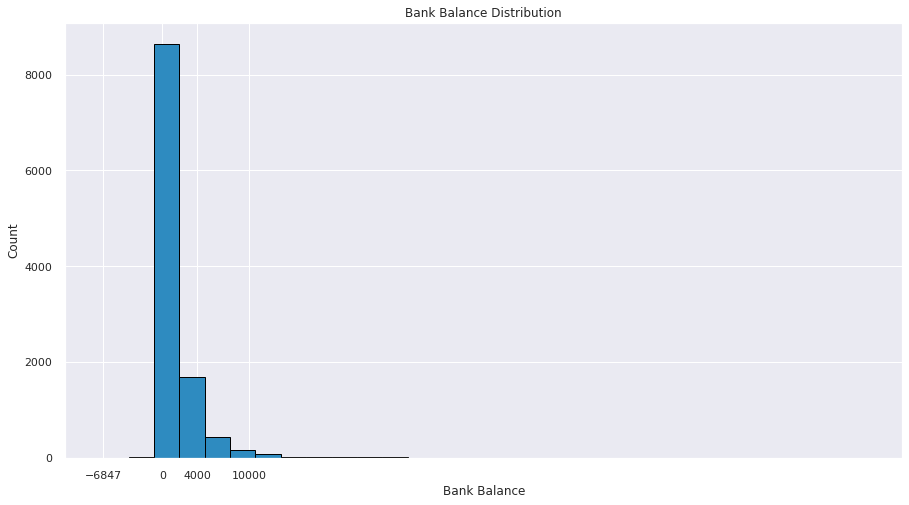

In [140]:
# Create histogram of bank balance distribution
fig, ax = plt.subplots(figsize=(15, 8))
plt.hist(bank_data['balance'], bins=30, color='#2E8BC0', edgecolor='black')

# Set x-axis labels and title
plt.xlabel('Bank Balance')
plt.ylabel('Count')
plt.xticks([-6847, 0, 4000, 10000])
plt.title('Bank Balance Distribution')

# Show plot
plt.show()

In [141]:
# assuming 'bd' is a pandas DataFrame
min_balance = bank_data['balance'].min()
bank_data['balance'] = pd.cut(bank_data['balance'], 
                       bins=[min_balance, 0, 4000, float('inf')], 
                       labels=['-veBal', '0-$4000', '$4000+'], 
                       include_lowest=True)

**DURATION**


```
The duration column shows time in seconds for the duration of the call. 
The column was converted into 3 categories of call time set in minutes: 
‘less than 10 minutes’, ‘between 10 and 20 minutes’, ’more than 20 minutes.A boxplot was plotted to check the distribution and outliers of variable duration.
```



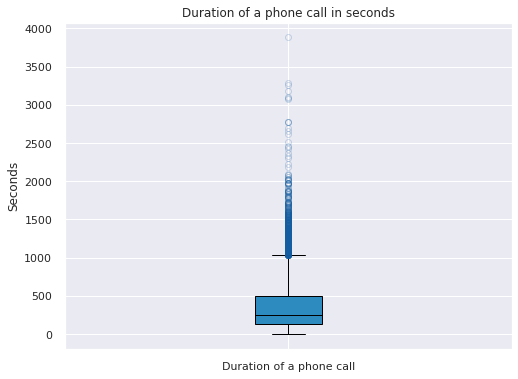

In [142]:
plt.figure(figsize=(8,6))
plt.boxplot(bank_data['duration'], 
            patch_artist=True, 
            boxprops=dict(facecolor='#2E8BC0', color='black'), 
            capprops=dict(color='black'), 
            whiskerprops=dict(color='black'), 
            flierprops=dict(markeredgecolor='#145DA0', alpha=0.2), 
            medianprops=dict(color='black'), 
            labels=['Duration of a phone call'])
plt.title('Duration of a phone call in seconds')
plt.ylabel('Seconds')
plt.show()

In [143]:
min_duration = bank_data['duration'].min()
bank_data['duration'] = pd.cut(bank_data['duration'], bins=[min_duration, 600, 1200, np.inf], labels=['<10mins', '10-20mins', '<20+mins'], include_lowest=True)

**CAMPAIGN**


```
Campaign shows number of contacts performed during this campaign and in the previous campaign if client was contacted. 
The continuous variable was transformed in three categorical variables of 
“1-3times if client was contacted 3 or less times, 4-6times if contact was made between 4 to 6 times, 
and finally +6 times if client was contacted more than 6 times A boxplot was plotted to check the distribution and outliers of variable campaign.
```



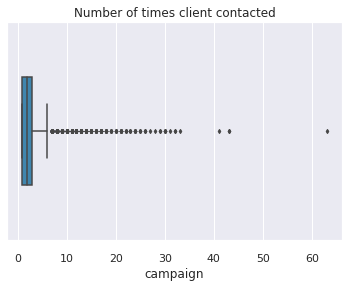

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='campaign', data=bank_data, color='#2E8BC0', fliersize=3, width=0.5)
plt.title('Number of times client contacted')
plt.show()


In [145]:
min_campaign = bank_data['campaign'].min()
bank_data['campaign'] = pd.cut(bank_data['campaign'], 
                         bins=[min_campaign, 3, 6, np.inf], 
                         labels=['1-3times', '4-6times', '+6times'], 
                         include_lowest=True)


- **PREVIOUS**
- **PDAYS**
- **MONTH**
```
The column ‘Previous’ shows the number of contacts performed before this campaign 
and ‘pdays’ shows number of days that passed by after the client was last contacted from a previous campaign. 
If ‘Previous’ = 0, this shows zero contact for the client and corresponds with -1 for ‘Pdays’ which shows client was not previously contacted. 
For this reason, the column pdays was discarded and previous column was transformed into two categories of PriorContact if client was contacted from a previous campaign and NoPriorContact if no contact was made.
```


```
Column attributes pdays, days and month were discarded from our data set for association rule. 
This is because these columns highly affect our output target. 
For this reason, the variables were discarded in order to have a realistic predictive model. Character variables in the data set where converted into factors to apply association rule.
```





In [146]:
bank_data['previous'] = pd.cut(bank_data['previous'], bins=[-float("inf"), 0, float("inf")], labels=['NoPriorContact', 'PriorContact'])

##Transaction data

In [147]:
bank_data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,senior_age,admin.,married,secondary,default=no,0-$4000,housing=yes,loan=no,unknown,5,may,10-20mins,1-3times,-1,NoPriorContact,unknown,deposit=yes
1,senior_age,admin.,married,secondary,default=no,0-$4000,housing=no,loan=no,unknown,5,may,<20+mins,1-3times,-1,NoPriorContact,unknown,deposit=yes
2,middle_aged_adult,technician,married,secondary,default=no,0-$4000,housing=yes,loan=no,unknown,5,may,<20+mins,1-3times,-1,NoPriorContact,unknown,deposit=yes
3,senior_age,services,married,secondary,default=no,0-$4000,housing=yes,loan=no,unknown,5,may,<10mins,1-3times,-1,NoPriorContact,unknown,deposit=yes
4,senior_age,admin.,married,tertiary,default=no,0-$4000,housing=no,loan=no,unknown,5,may,10-20mins,1-3times,-1,NoPriorContact,unknown,deposit=yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,young_adult,blue-collar,single,primary,default=no,0-$4000,housing=yes,loan=no,cellular,20,apr,<10mins,1-3times,-1,NoPriorContact,unknown,deposit=no
11158,middle_aged_adult,services,married,secondary,default=no,0-$4000,housing=no,loan=no,unknown,16,jun,<10mins,4-6times,-1,NoPriorContact,unknown,deposit=no
11159,young_adult,technician,single,secondary,default=no,0-$4000,housing=no,loan=no,cellular,19,aug,<10mins,1-3times,-1,NoPriorContact,unknown,deposit=no
11160,middle_aged_adult,technician,married,secondary,default=no,-veBal,housing=no,loan=yes,cellular,8,may,<10mins,1-3times,172,PriorContact,failure,deposit=no


In [148]:
bank_data = bank_data.drop(columns=['pdays', 'month', 'day'])
bd_test = bank_data.apply(lambda x: pd.factorize(x)[0])

In [149]:
bd_test

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,previous,poutcome,deposit
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
2,1,1,0,0,0,0,0,0,0,1,0,0,0,0
3,0,2,0,0,0,0,0,0,0,2,0,0,0,0
4,0,0,0,1,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,2,5,1,2,0,0,0,0,1,2,0,0,0,1
11158,1,2,0,0,0,0,1,0,0,2,1,0,0,1
11159,2,1,1,0,0,0,1,0,1,2,0,0,0,1
11160,1,1,0,0,0,1,1,1,1,2,0,1,2,1


In [150]:
bd_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        11162 non-null  int64
 1   job        11162 non-null  int64
 2   marital    11162 non-null  int64
 3   education  11162 non-null  int64
 4   default    11162 non-null  int64
 5   balance    11162 non-null  int64
 6   housing    11162 non-null  int64
 7   loan       11162 non-null  int64
 8   contact    11162 non-null  int64
 9   duration   11162 non-null  int64
 10  campaign   11162 non-null  int64
 11  previous   11162 non-null  int64
 12  poutcome   11162 non-null  int64
 13  deposit    11162 non-null  int64
dtypes: int64(14)
memory usage: 1.2 MB


In [151]:
bank_data

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,previous,poutcome,deposit
0,senior_age,admin.,married,secondary,default=no,0-$4000,housing=yes,loan=no,unknown,10-20mins,1-3times,NoPriorContact,unknown,deposit=yes
1,senior_age,admin.,married,secondary,default=no,0-$4000,housing=no,loan=no,unknown,<20+mins,1-3times,NoPriorContact,unknown,deposit=yes
2,middle_aged_adult,technician,married,secondary,default=no,0-$4000,housing=yes,loan=no,unknown,<20+mins,1-3times,NoPriorContact,unknown,deposit=yes
3,senior_age,services,married,secondary,default=no,0-$4000,housing=yes,loan=no,unknown,<10mins,1-3times,NoPriorContact,unknown,deposit=yes
4,senior_age,admin.,married,tertiary,default=no,0-$4000,housing=no,loan=no,unknown,10-20mins,1-3times,NoPriorContact,unknown,deposit=yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,young_adult,blue-collar,single,primary,default=no,0-$4000,housing=yes,loan=no,cellular,<10mins,1-3times,NoPriorContact,unknown,deposit=no
11158,middle_aged_adult,services,married,secondary,default=no,0-$4000,housing=no,loan=no,unknown,<10mins,4-6times,NoPriorContact,unknown,deposit=no
11159,young_adult,technician,single,secondary,default=no,0-$4000,housing=no,loan=no,cellular,<10mins,1-3times,NoPriorContact,unknown,deposit=no
11160,middle_aged_adult,technician,married,secondary,default=no,-veBal,housing=no,loan=yes,cellular,<10mins,1-3times,PriorContact,failure,deposit=no


In [152]:
bank_data.describe()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,previous,poutcome,deposit
count,11162,11162,11162,11162,11162,11162,11162,11162,11162,11162,11162,11162,11162,11162
unique,5,12,3,4,2,3,2,2,3,3,3,2,4,2
top,middle_aged_adult,management,married,secondary,default=no,0-$4000,housing=no,loan=no,cellular,<10mins,1-3times,NoPriorContact,unknown,deposit=no
freq,4320,2566,6351,5476,10994,8622,5881,9702,8042,9010,9147,8324,8326,5873


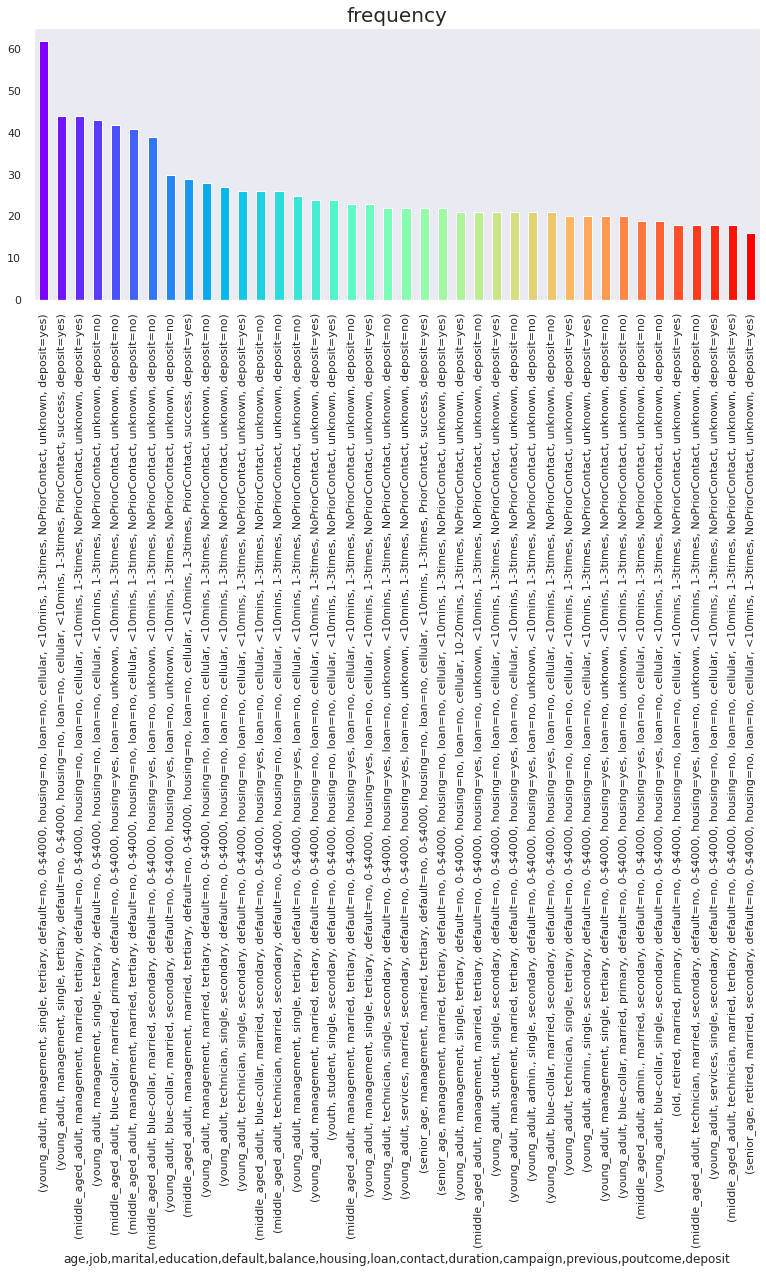

In [153]:
color = plt.cm.rainbow(np.linspace(0, 1, 40))
bank_data.value_counts().head(40).plot.bar(color = color, figsize=(13,5))
plt.title('frequency', fontsize = 20)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()

In [154]:
# Getting the list of transactions from the dataset
transactions = []
for i in range(0, len(bank_data)):
    transactions.append([str(bank_data.values[i,j]) for j in range(0, len(bank_data.columns))])

In [155]:
transactions[:1]

[['senior_age',
  'admin.',
  'married',
  'secondary',
  'default=no',
  '0-$4000',
  'housing=yes',
  'loan=no',
  'unknown',
  '10-20mins',
  '1-3times',
  'NoPriorContact',
  'unknown',
  'deposit=yes']]

##Rules

In [156]:
from itertools import permutations

# Extract unique items.
flattened = [item for transaction in transactions for item in transaction]
items = list(set(flattened))

In [157]:
print('# of items:',len(items))
print(list(items))

# of items: 47
['cellular', 'student', '0-$4000', 'self-employed', 'retired', 'unemployed', '$4000+', 'senior_age', '<20+mins', 'married', 'default=yes', '+6times', 'youth', 'technician', 'PriorContact', 'loan=yes', 'deposit=no', 'loan=no', '10-20mins', 'single', 'housing=yes', 'failure', '1-3times', 'young_adult', 'success', 'management', 'secondary', '-veBal', 'divorced', '4-6times', 'housing=no', 'middle_aged_adult', 'admin.', 'other', 'telephone', 'services', 'primary', 'unknown', 'deposit=yes', '<10mins', 'blue-collar', 'default=no', 'old', 'entrepreneur', 'tertiary', 'NoPriorContact', 'housemaid']


In [158]:
if 'nan' in items: items.remove('nan')
print(list(items))

['cellular', 'student', '0-$4000', 'self-employed', 'retired', 'unemployed', '$4000+', 'senior_age', '<20+mins', 'married', 'default=yes', '+6times', 'youth', 'technician', 'PriorContact', 'loan=yes', 'deposit=no', 'loan=no', '10-20mins', 'single', 'housing=yes', 'failure', '1-3times', 'young_adult', 'success', 'management', 'secondary', '-veBal', 'divorced', '4-6times', 'housing=no', 'middle_aged_adult', 'admin.', 'other', 'telephone', 'services', 'primary', 'unknown', 'deposit=yes', '<10mins', 'blue-collar', 'default=no', 'old', 'entrepreneur', 'tertiary', 'NoPriorContact', 'housemaid']


In [159]:
# Compute and print rules.
rules = list(permutations(items, 2))
print('# of rules:',len(rules))
print(rules[:5])

# of rules: 2162
[('cellular', 'student'), ('cellular', '0-$4000'), ('cellular', 'self-employed'), ('cellular', 'retired'), ('cellular', 'unemployed')]


In [160]:
rules

[('cellular', 'student'),
 ('cellular', '0-$4000'),
 ('cellular', 'self-employed'),
 ('cellular', 'retired'),
 ('cellular', 'unemployed'),
 ('cellular', '$4000+'),
 ('cellular', 'senior_age'),
 ('cellular', '<20+mins'),
 ('cellular', 'married'),
 ('cellular', 'default=yes'),
 ('cellular', '+6times'),
 ('cellular', 'youth'),
 ('cellular', 'technician'),
 ('cellular', 'PriorContact'),
 ('cellular', 'loan=yes'),
 ('cellular', 'deposit=no'),
 ('cellular', 'loan=no'),
 ('cellular', '10-20mins'),
 ('cellular', 'single'),
 ('cellular', 'housing=yes'),
 ('cellular', 'failure'),
 ('cellular', '1-3times'),
 ('cellular', 'young_adult'),
 ('cellular', 'success'),
 ('cellular', 'management'),
 ('cellular', 'secondary'),
 ('cellular', '-veBal'),
 ('cellular', 'divorced'),
 ('cellular', '4-6times'),
 ('cellular', 'housing=no'),
 ('cellular', 'middle_aged_adult'),
 ('cellular', 'admin.'),
 ('cellular', 'other'),
 ('cellular', 'telephone'),
 ('cellular', 'services'),
 ('cellular', 'primary'),
 ('cellul

In [161]:
pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.8/481.8 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 KB 5.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.8/105.8 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

#####**One-hot encoding transaction data**
Throughout we will use a common pipeline for preprocessing data for use in market basket analysis. The first step is to import a pandas DataFrame and select the column that contains transactions. Each transaction in the column will be a string that consists of a number of items, each separated by a comma. The next step is to use a lambda function to split each transaction string into a list, thereby transforming the column into a list of lists. Then we will transform the transactions into a one-hot encoded DataFrame, where each column consists of TRUE and FALSE values that indicate whether an item was included in a transaction.

###ต้อง one-hot เพื่อแปลงเป็น transaction data แล้วทำให้ ข้อมูลดูยาก ถ้าไม่ทำ one hot ก็จะหา mean support ไม่ได้ หรือได้ แต่นุไม่รู้ 

In [164]:
# Import the transaction encoder function from mlxtend
from mlxtend.preprocessing import TransactionEncoder

# Instantiate transaction encoder and identify unique items
encoder = TransactionEncoder().fit(transactions)

# One-hot encode transactions
onehot = encoder.transform(transactions)

# Convert one-hot encoded data to DataFrame
onehot = pd.DataFrame(onehot, columns = encoder.columns_)

# Print the one-hot encoded transaction dataset
onehot.head()

,$4000+,+6times,-veBal,0-$4000,1-3times,10-20mins,4-6times,<10mins,<20+mins,NoPriorContact,PriorContact,admin.,blue-collar,cellular,default=no,default=yes,deposit=no,deposit=yes,divorced,entrepreneur,failure,housemaid,housing=no,housing=yes,loan=no,loan=yes,management,married,middle_aged_adult,old,other,primary,retired,secondary,self-employed,senior_age,services,single,student,success,technician,telephone,tertiary,unemployed,unknown,young_adult,youth
0,False,False,False,True,True,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,False,False,False,True,True,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False
1,False,False,False,True,True,False,False,False,True,True,False,True,False,False,True,False,False,True,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False
2,False,False,False,True,True,False,False,False,True,True,False,False,False,False,True,False,False,True,False,False,False,False,False,True,True,False,False,True,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False
3,False,False,False,True,True,False,False,True,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,True,True,False,False,True,False,False,False,False,False,True,False,True,True,False,False,False,False,False,False,False,True,False,False
4,False,False,False,True,True,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False


In [165]:
onehot.columns

Index(['$4000+', '+6times', '-veBal', '0-$4000', '1-3times', '10-20mins',
       '4-6times', '<10mins', '<20+mins', 'NoPriorContact', 'PriorContact',
       'admin.', 'blue-collar', 'cellular', 'default=no', 'default=yes',
       'deposit=no', 'deposit=yes', 'divorced', 'entrepreneur', 'failure',
       'housemaid', 'housing=no', 'housing=yes', 'loan=no', 'loan=yes',
       'management', 'married', 'middle_aged_adult', 'old', 'other', 'primary',
       'retired', 'secondary', 'self-employed', 'senior_age', 'services',
       'single', 'student', 'success', 'technician', 'telephone', 'tertiary',
       'unemployed', 'unknown', 'young_adult', 'youth'],
      dtype='object')

##Prunning

In [166]:
# Compute the support
support = onehot.mean()
support = pd.DataFrame(support, columns=['support']).sort_values('support',ascending=False)

# Print the support
support.head()

,support
default=no,0.984949
loan=no,0.869199
1-3times,0.819477
<10mins,0.807203
0-$4000,0.772442


In [167]:
support.describe()

,support
count,47.000000
mean,0.292627
std,0.284555
min,0.015051
25%,0.069522
50%,0.158753
75%,0.482216
max,0.984949


###**Confidence and lift**

###Analysis data with support

In [168]:
# Compute support for housing=yes and deposit=yes
support1 = np.logical_and(onehot['housing=yes'], onehot['deposit=yes']).mean()
# Print support values
print("have house and suscript term of deposit: %.2f" % support1)

# Compute support for housing=yes and deposit=no
support2 = np.logical_and(onehot['housing=yes'], onehot['deposit=no']).mean()
# Print support values
print("have house and did not suscript term of deposit: %.2f" % support2)

# Compute support for married and deposit=yes
support3 = np.logical_and(onehot['married'], onehot['deposit=yes']).mean()
# Print support values
print("Married and suscript term of deposit: %.2f" % support3)

# Compute support for married and deposit=no
support4 = np.logical_and(onehot['married'], onehot['deposit=no']).mean()
# Print support values
print("Married and did not suscript term of deposit: %.2f" % support4)


have house and suscript term of deposit: 0.17
have house and did not suscript term of deposit: 0.30
Married and suscript term of deposit: 0.25
Married and did not suscript term of deposit: 0.32


####Computing the support metric

In [169]:
# Add a married+deposit=yes column to the DataFrame onehot
onehot['married+deposit=yes'] = np.logical_and(onehot['married'], onehot['deposit=yes'])

# Compute the support
support = onehot.mean()
val = support.loc['married+deposit=yes']

# Print the support values
print(f'married+deposit=yes support = {val}')

married+deposit=yes support = 0.24681956638595234


####Refining support with confidence

In [170]:
# Compute support for married and deposit=yes 0.24681956638595234

support = np.logical_and(onehot['married'], onehot['deposit=yes']).mean()

# Compute support for married 0.5689840530370901
supportM = onehot['married'].mean()

# Compute support for deposit=yes 0.4738398136534671
supportY = onehot['deposit=yes'].mean()

# Compute confidence for both rules
confidenceY = support / supportY
confidenceM = support / supportM

# Print results

print('married = {0:.2f}, deposit=yes = {1:.2f}'.format(confidenceM, confidenceY))

married = 0.43, deposit=yes = 0.52


####lift

In [171]:
# Compute lift
lift = support / (supportM * supportY)

# Print lift
print("Lift: %.2f" % lift)

Lift: 0.92




```
As it turns out, lift is less than  1.0
 . This does not give us good confidence that the association rule we recommended did not arise by random chance.
```



#**Problem Sove with R**
จากตรงนี้ ถ้าต้องการหา support lift confidence of more item เราต้องใช้ coluumn feature หาเอาทีละตัว ยังไม่ค่อยเห็นภาพมากพอ แต่ ทำใน Python plot ไม่ขึ้น เลยไปใช้ R ทำค่ะ



##**Item Frequency**
Item Frequency shows the items in the dataset that appear most. As we can see that most clients in the data set have not defaulted in their loan obligations followed by loan=no which shows the number of Clients that have not accessed any loan facilities.

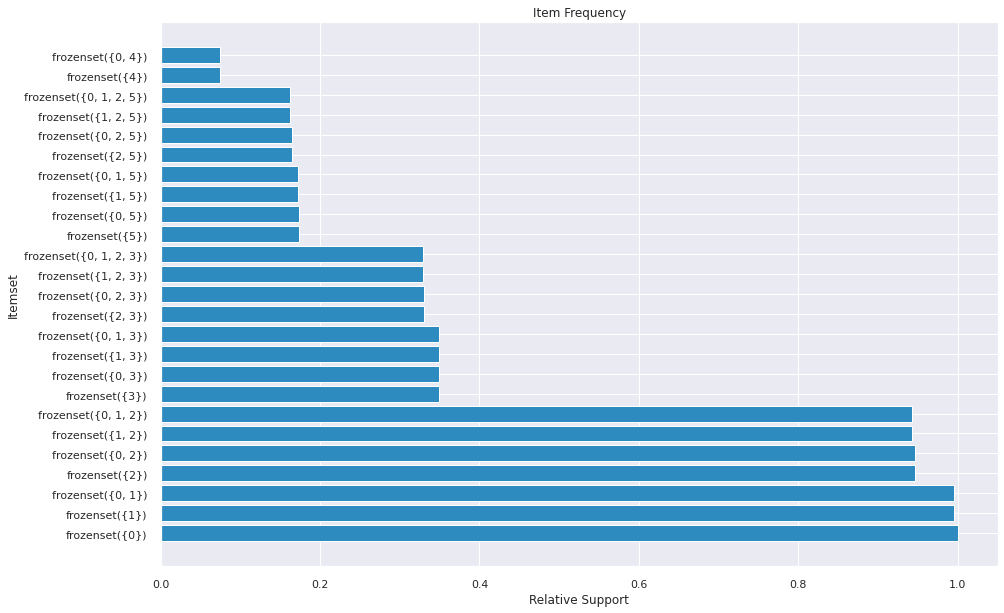

In [172]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
# Convert dataframe to list of transactions
transactions = bd_test.values.tolist()

# Encode transactions into a binary matrix
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# Generate frequent itemsets using apriori algorithm
frequent_itemsets = apriori(df, min_support=0.05, use_colnames=True)

# Sort itemsets by frequency and plot top 25
plt.figure(figsize=(15, 10))
top_items = frequent_itemsets.nlargest(25, 'support')
plt.barh(top_items['itemsets'].astype(str), top_items['support'], color='#2E8BC0')
plt.title('Item Frequency')
plt.xlabel('Relative Support')
plt.ylabel('Itemset')
plt.show()

In [173]:
from mlxtend.frequent_patterns import apriori, association_rules

# assuming that bd_test is a pandas DataFrame
frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True, max_len=5)
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)


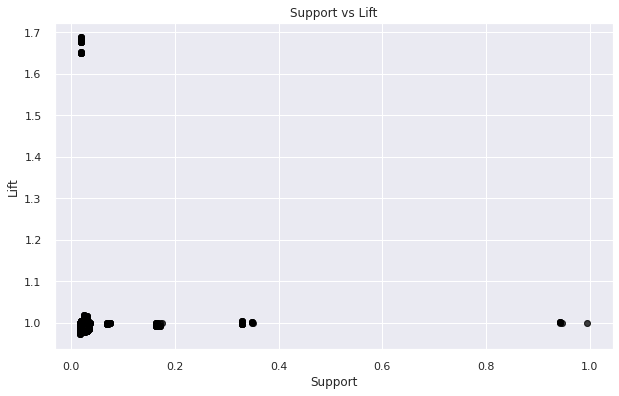

In [174]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
rules = association_rules(apriori(df, min_support=0.01, use_colnames=True, max_len=5), metric="lift", min_threshold=0.95)
rules = rules.sort_values(['lift'], ascending=[True])
plt.figure(figsize=(10,6))
plt.scatter(rules["support"], rules["lift"], alpha=0.5, color='black')
plt.xlabel('Support')
plt.ylabel('Lift')
plt.title('Support vs Lift')
plt.show()

#GeneralRules

In [176]:
general_rules_20 = rules[:20].sort_values('lift')
print(general_rules_20[:10].to_string(index=False))

antecedents consequents  antecedent support  consequent support  support  confidence     lift  leverage  conviction
  (0, 1, 2)      (3, 5)            0.942663            0.018276 0.016753    0.017772 0.972423 -0.000475    0.999487
     (1, 2)      (3, 5)            0.942663            0.018276 0.016753    0.017772 0.972423 -0.000475    0.999487
     (1, 2)   (0, 3, 5)            0.942663            0.018276 0.016753    0.017772 0.972423 -0.000475    0.999487
     (3, 5)   (0, 1, 2)            0.018276            0.942663 0.016753    0.916667 0.972423 -0.000475    0.688049
  (0, 3, 5)      (1, 2)            0.018276            0.942663 0.016753    0.916667 0.972423 -0.000475    0.688049
     (3, 5)      (1, 2)            0.018276            0.942663 0.016753    0.916667 0.972423 -0.000475    0.688049
     (1, 2)      (0, 7)            0.942663            0.029385 0.027056    0.028702 0.976735 -0.000644    0.999296
     (1, 2)         (7)            0.942663            0.029385 0.027056

In [177]:
pip install pyvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 KB 11.2 MB/s eta 0:00:00


In [178]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from pyvis.network import Network

frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True, max_len=5)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

general_rules20 = rules.nlargest(20, "lift")
general_rules20_str = general_rules20.astype(str)
edges = general_rules20_str.apply(lambda x: (x["antecedents"], x["consequents"], x["lift"]), axis=1)
nodes = set(general_rules20_str["antecedents"]).union(set(general_rules20_str["consequents"]))
g = Network(height="750px", width="100%", bgcolor="#222222", font_color="white", notebook=True)
g.barnes_hut()
g.add_nodes(nodes)
for e in edges:
    g.add_edge(e[0], e[1], value=e[2])
    neighbor_map = g.get_adj_list()
g.show("my_graph.html")


my_graph.html


In [179]:
from IPython.display import IFrame
IFrame(src='./my_graph.html', width=700, height=600)

# R code

##Code
#set rules
rules<- apriori(bd_test, parameter = list(supp=0.01, conf=0.95, maxlen = 5))
rules<- sort(rules, decreasing = FALSE, by ="lift")
#header 20 rows
generalRules20<- head(rules, n = 20, by = "lift")
inspect(generalRules20[1:10], linebreak = FALSE)
plot(generalRules20, method = "graph")
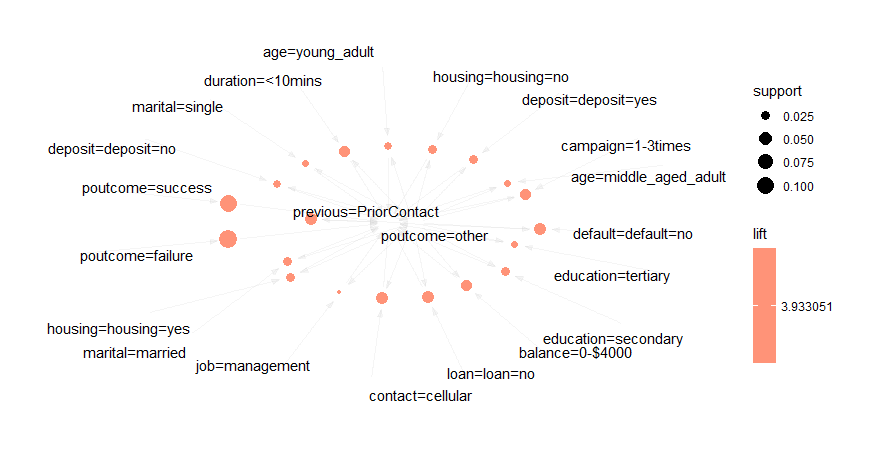

#deposit=yes_rules
yesrules<- apriori(bd_test, parameter = list(supp=0.01, conf = 0.85, maxlen = 6), 
                   appearance =list(default = "lhs", rhs="deposit=deposit=yes"),
                   control=list(verbose=F))
summary(yesrules)

#deposit=yes_rules by confidence
conf_yesrules<- sort(yesrules , by ="confidence", decreasing = T )
inspect(conf_yesrules[1:10], linebreak = FALSE)

subrules <- head(conf_yesrules,8)
plot(subrules, method="graph", interactive=FALSE)
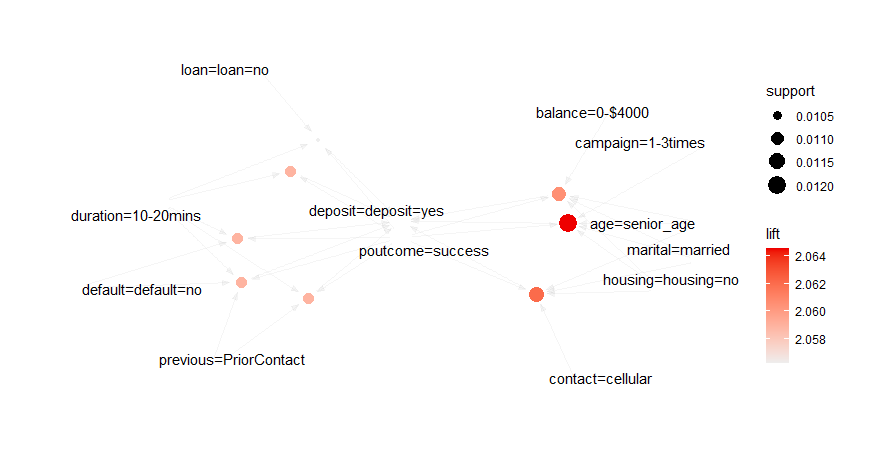
#deposit=yes_rules rules by support
supp_yesrules <- sort(yesrules, by='support', decreasing=TRUE)
inspect(supp_yesrules[1:10], linebreak = FALSE)
subrules <- head(supp_yesrules,10)
plot(subrules, method="graph", interactive=FALSE)
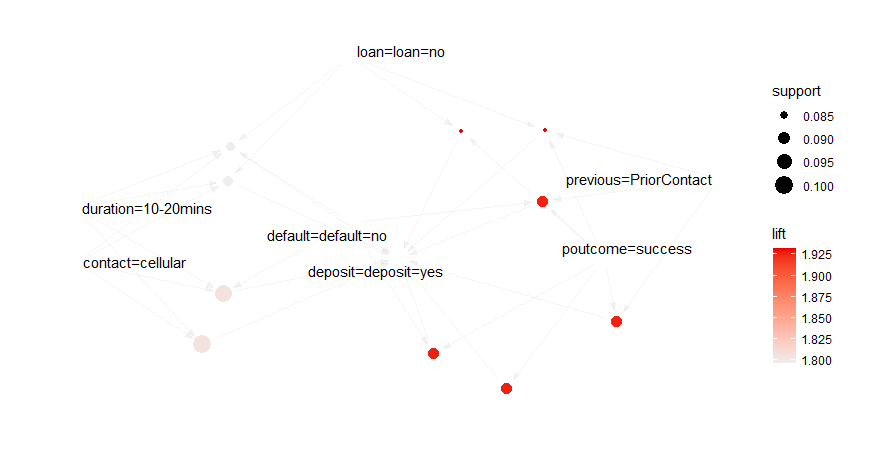
#deposit=yes_rules rules by lifted
lift_yesrules <- sort(yesrules, by='lift', decreasing=TRUE)
inspect(lift_yesrules[1:10], linebreak = FALSE)
subrules <- head(lift_yesrules,10)
plot(subrules, method="graph", interactive=FALSE)
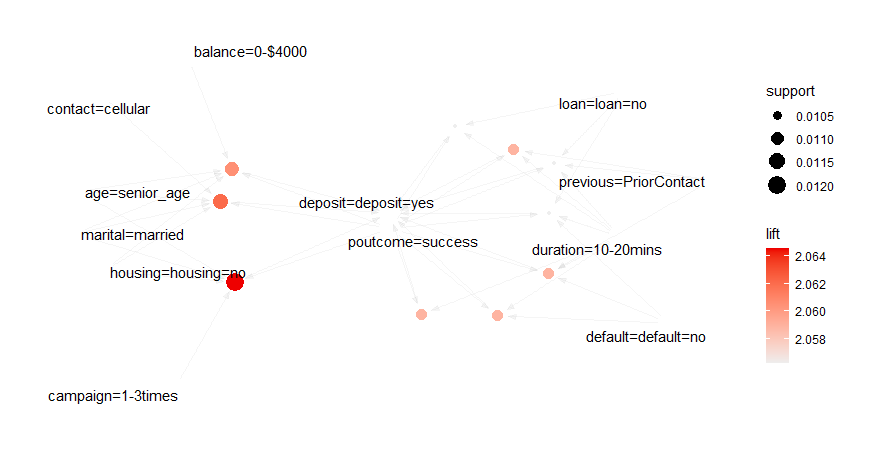





##Code con.
#deposit=no_rules
norules<- apriori(bd_test, parameter = list(supp=0.01, conf = 0.90, maxlen = 6), 
                  appearance =list(default = "lhs", rhs="deposit=deposit=no"),
                  control=list(verbose=F))

#deposit=no_rules by Confidence
conf_norules<- sort(norules, by ="confidence", decreasing = TRUE)
inspect(conf_norules[1:5], linebreak = FALSE)
subrules <- head(conf_norules,8)
plot(subrules, method="graph", interactive=FALSE)
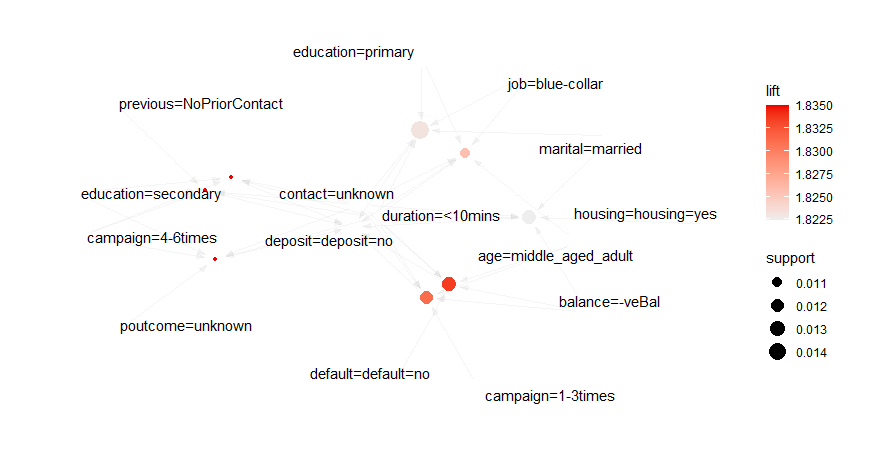
#deposit=no_rules by support
supp_norules <- sort(norules, by='support', decreasing=TRUE)
inspect(supp_norules[1:5], linebreak = FALSE)
subrules <- head(supp_norules,6)
plot(subrules, method="graph", interactive=FALSE)
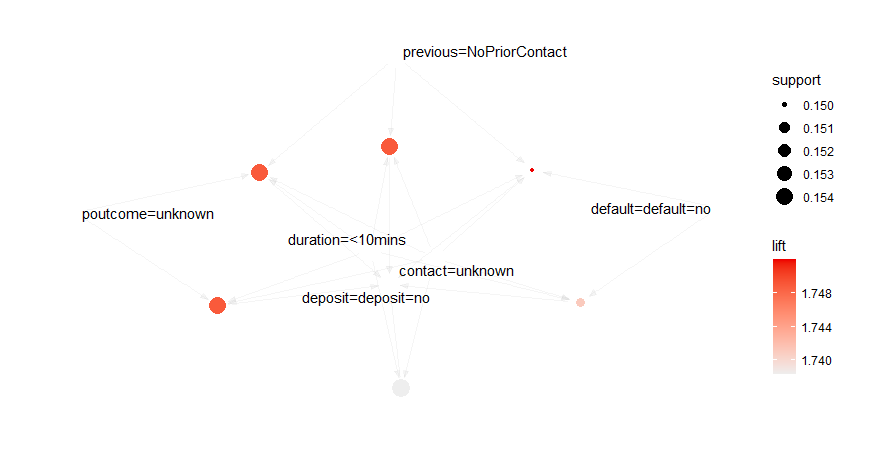
#deposit=no_rules by lift
lift_norules <- sort(norules, by='lift', decreasing=TRUE)
inspect(lift_norules[1:5], linebreak = FALSE)
subrules <- head(lift_norules,7)
plot(subrules, method="graph", interactive=FALSE)
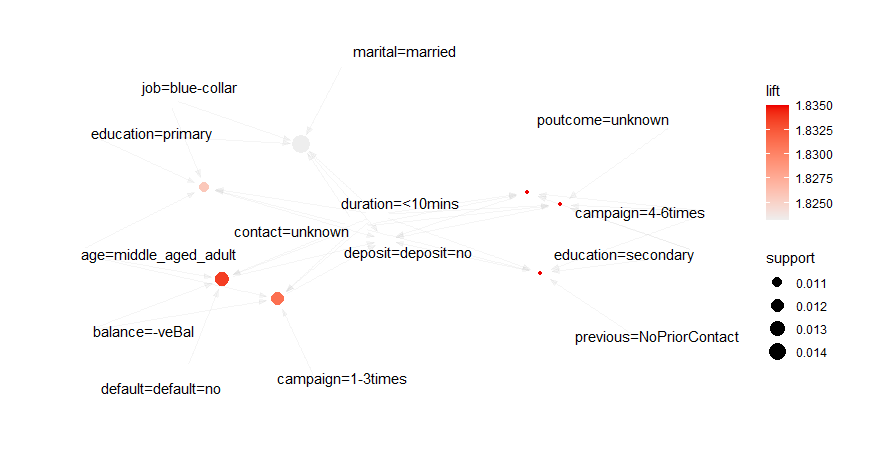

In [ ]:

#scale numeric column "AGE"
ggplot(bank, aes(age)) + geom_histogram(aes(y=..density..),color="black", fill="skyblue") + 
  scale_x_continuous(breaks=c(18,24,35,50,65,95))+ theme_classic() + ggtitle('Age Distributition') + geom_density(alpha=.2, fill='black',color="#FF6666", linetype=0)
bd$age <- cut(bd$age, breaks=c(18,24,35,50,65,Inf), labels=c('youth','young_adult','middle_aged_adult','senior_age','old'),include.lowest = TRUE)



```
#The fields that contained “YES” or “NO” like ‘Default’, ’housing’, ’loan’, ‘deposit’ was transformed to “variable name = variable name = YES/NO” so that it would be clear in the rules what attribute is related to the YES or NO.
#change variable names with yes/no.
```
bd$default <- dplyr::recode(bd$default, no='default=no',yes='default=yes',unknown='default=unknown')
bd$housing <- dplyr::recode(bd$housing, no='housing=no',yes='housing=yes',unknown='housing=unknown')
bd$loan <- dplyr::recode(bd$loan, no='loan=no',yes='loan=yes',unknown='loan=unknown')
bd$deposit <- dplyr::recode(bd$deposit, no='deposit=no',yes='deposit=yes')

```
#The data for bank balance was therefore put into four separate ranges. A histogram was used to check the distribution of the data and also considering the minimum and the maximum value. The four categories were: -$6847-$0, $0-$4000, and $4000-$81204.
```
ggplot(bank, aes(balance)) + geom_histogram(color="black", fill="#2E8BC0") + 
  scale_x_continuous(breaks=c(-6847,0,4000,10000))+theme_classic() + ggtitle('Bank Balance Distributition')
min_balance <- min(bd$balance)
bd$balance = cut(bd$balance, breaks=c(min_balance, 0,4000,Inf), labels= c('-veBal','0-$4000', '$4000+'),include.lowest = TRUE)
```
#The duration column shows time in seconds for the duration of the call. The column was converted into 3 categories of call time set in minutes: ‘less than 10 minutes’, ‘between 10 and 20 minutes’, ’more than 20 minutes.A boxplot was plotted to check the distribution and outliers of variable duration.
```
ggplot(bank, aes(duration,color=duration)) + 
  geom_boxplot(color="black", fill="#2E8BC0",outlier.color='#145DA0',outlier.alpha=0.2) +
  theme_classic() + ggtitle('Duration of a phone call in seconds')
min_duration <- min(bd$duration)
bd$duration <- cut(bd$duration, breaks = c(min_duration, 600,1200,Inf),labels= c('<10mins','10-20mins', '<20+mins'),include.lowest = TRUE)


```
##Campaign shows number of contacts performed during this campaign and in the previous campaign if client was contacted. The continuous variable was transformed in three categorical variables of “1-3times if client was contacted 3 or less times, 4-6times if contact was made between 4 to 6 times, and finally +6 times if client was contacted more than 6 times A boxplot was plotted to check the distribution and outliers of variable campaign.
```

ggplot(bd, aes(campaign,color=campaign)) + 
  geom_boxplot(color="black", fill="#2E8BC0",outlier.color='#145DA0',outlier.alpha=0.2) +
  theme_classic() + ggtitle('Number of times client contacted')
min_campaign <- min(bd$campaign)
bd$campaign <- cut(bd$campaign, breaks = c(min_campaign, 3,6, Inf), labels= c("1-3times", "4-6times","+6times"), include.lowest = TRUE)
bd$previous <- cut(bd$previous, breaks= c(-Inf,0,Inf), labels= c('NoPriorContact','PriorContact'))
# DELETE col Previous
bd <- select(bd, -pdays)
bd <- select(bd, -month)
bd <- select(bd,-day)
bd_test <- as.data.frame(unclass(bd), stringsAsFactors = TRUE)
summary(bd_test)


##set rules
rules<- apriori(bd_test, parameter = list(supp=0.01, conf=0.95, maxlen = 5))
rules<- sort(rules, decreasing = FALSE, by ="lift")
#header 20 rows
generalRules20<- head(rules, n = 20, by = "lift")
inspect(generalRules20[1:10], linebreak = FALSE)
plot(generalRules20, method = "graph")


#deposit=yes_rules
yesrules<- apriori(bd_test, parameter = list(supp=0.01, conf = 0.85, maxlen = 6), 
                   appearance =list(default = "lhs", rhs="deposit=deposit=yes"),
                   control=list(verbose=F))
summary(yesrules)

#deposit=yes_rules by confidence
conf_yesrules<- sort(yesrules , by ="confidence", decreasing = T )
inspect(conf_yesrules[1:10], linebreak = FALSE)

subrules <- head(conf_yesrules,8)
plot(subrules, method="graph", interactive=FALSE)

#deposit=yes_rules rules by support
supp_yesrules <- sort(yesrules, by='support', decreasing=TRUE)
inspect(supp_yesrules[1:10], linebreak = FALSE)
subrules <- head(supp_yesrules,10)
plot(subrules, method="graph", interactive=FALSE)

#deposit=yes_rules rules by lifted
lift_yesrules <- sort(yesrules, by='lift', decreasing=TRUE)
inspect(lift_yesrules[1:10], linebreak = FALSE)
subrules <- head(lift_yesrules,10)
plot(subrules, method="graph", interactive=FALSE)



#deposit=no_rules
norules<- apriori(bd_test, parameter = list(supp=0.01, conf = 0.90, maxlen = 6), 
                  appearance =list(default = "lhs", rhs="deposit=deposit=no"),
                  control=list(verbose=F))

#deposit=no_rules by Confidence
conf_norules<- sort(norules, by ="confidence", decreasing = TRUE)
inspect(conf_norules[1:5], linebreak = FALSE)
subrules <- head(conf_norules,8)
plot(subrules, method="graph", interactive=FALSE)

#deposit=no_rules by support
supp_norules <- sort(norules, by='support', decreasing=TRUE)
inspect(supp_norules[1:5], linebreak = FALSE)
subrules <- head(supp_norules,6)
plot(subrules, method="graph", interactive=FALSE)

#deposit=no_rules by lift
lift_norules <- sort(norules, by='lift', decreasing=TRUE)
inspect(lift_norules[1:5], linebreak = FALSE)
subrules <- head(lift_norules,7)
plot(subrules, method="graph", interactive=FALSE)




#Conclusion
Implementing the Association Rules measure can be extremely useful in the process of establishing behavior patterns. Apriori algorithm can be used to extract rules that can help in target marketing for Banks and financial institutions. The algorithm is a great technique for an extraction of useful information and remarks from huge dataset.

**Interesting rules for yes rules (Deposit=yes)**

- Customer with outcomes of the previous campaign equal success, who are in the senior age category (50-65 years), married and do not have a housing loan are most likely to subscribe to a term deposit. The client in this category can be targeted for marketing campaign.

- Customer with outcomes of the previous campaign equal success and were contacted between 10 to 20 minutes are most likely to subscribe to a term deposit. The client in this category can also be targeted for marketing campaign.

**Interesting rules for no rules (Deposit=no)**
- Customer with a secondary education level, contacted between 4 to 6 times during the campaign for less than 10 minutes call duration and with an unknown contact type will likely not subscribe for a term deposit.

- Customer who is in the middle-age category (36-50 years), with a negative bank balance and was contacted for duration of less than 10 minutes with an unknown contact type, will likely not subscribe for a term deposit.